# COSC2673 - Machine Learning - Assignment 2
### Authors: Louise Platts (S3908818) & Samuel Macintyre (S3888492)

# Classifying Images of Road Traffic Signs

#### Libraries Required

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

import tensorflow as tf
print(tf.__version__)
print(get_available_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
['/device:CPU:0', '/device:GPU:0']
Num GPUs Available:  1


In [3]:
# import statements
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import glob
from PIL import Image
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform



# Data Understanding & Data Preparation

In [4]:
def image_reader(path):
    image_list = []
    for filepath in glob.glob(path, recursive=True):
        shape = filepath.split("\\")[-3]
        type = filepath.split("\\")[-2]
        filename = filepath.split("\\")[-1]
        label = filename.split(".")[0]
        
        image_list.append({"filepath": filepath,'filename':filename,'label':label,'shape':shape,'type':type})

    dataset = pd.DataFrame(image_list)

    return dataset

def drop_unused_target(train, val, col):
    train1 = train.copy()
    val1 = val.copy()

    train1 = train1.drop(col,axis=1)
    val1 = val1.drop(col,axis=1)
    return train1, val1

In [5]:
raw_data = image_reader("./trafficsigns_dataset/*/*/*.png")
# raw_data.head()

# Split data into train and test
train_data, val_data = train_test_split(raw_data, test_size=0.2, random_state=42)

TOTAL_SHAPES = raw_data['shape'].nunique()
TOTAL_TYPES = raw_data['type'].nunique()

SHAPE_NAMES = raw_data['shape'].unique()
TYPE_NAMES = raw_data['type'].unique()

DIM = 28
RES_DIM = 28

test_image = Image.open(raw_data['filepath'][0])
NUM_BANDS = len(test_image.getbands())

print(f"Train data : {train_data.shape[0]}, Val Data: {val_data.shape[0]}")
print(f"Shape Classes:{SHAPE_NAMES}")
print(f"Type Classes: {TYPE_NAMES}")
print(f"Num Shape Classes: {TOTAL_SHAPES}, Num Type Classes: {TOTAL_TYPES}")


# Split training and validation into frames for respective classification type
shape_train_data, shape_val_data = drop_unused_target(train_data, val_data, "type")
type_train_data, type_val_data = drop_unused_target(train_data, val_data, "shape")


Train data : 2959, Val Data: 740
Shape Classes:['diamond' 'hex' 'round' 'square' 'triangle']
Type Classes: ['rightofway' 'stop' 'bicycle' 'limitedtraffic' 'noentry' 'noparking'
 'roundabout' 'speed' 'trafficdirective' 'traveldirection' 'continue'
 'crossing' 'laneend' 'parking' 'giveway' 'warning']
Num Shape Classes: 5, Num Type Classes: 16


In [5]:
def make_subplot(x,data,ax,order,title):
    fontsize = 12
    sns.countplot(x=x,data=data, order=order, ax=ax)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(x, fontsize=fontsize)
    ax.set_ylabel("Count", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis="x",rotation=90)


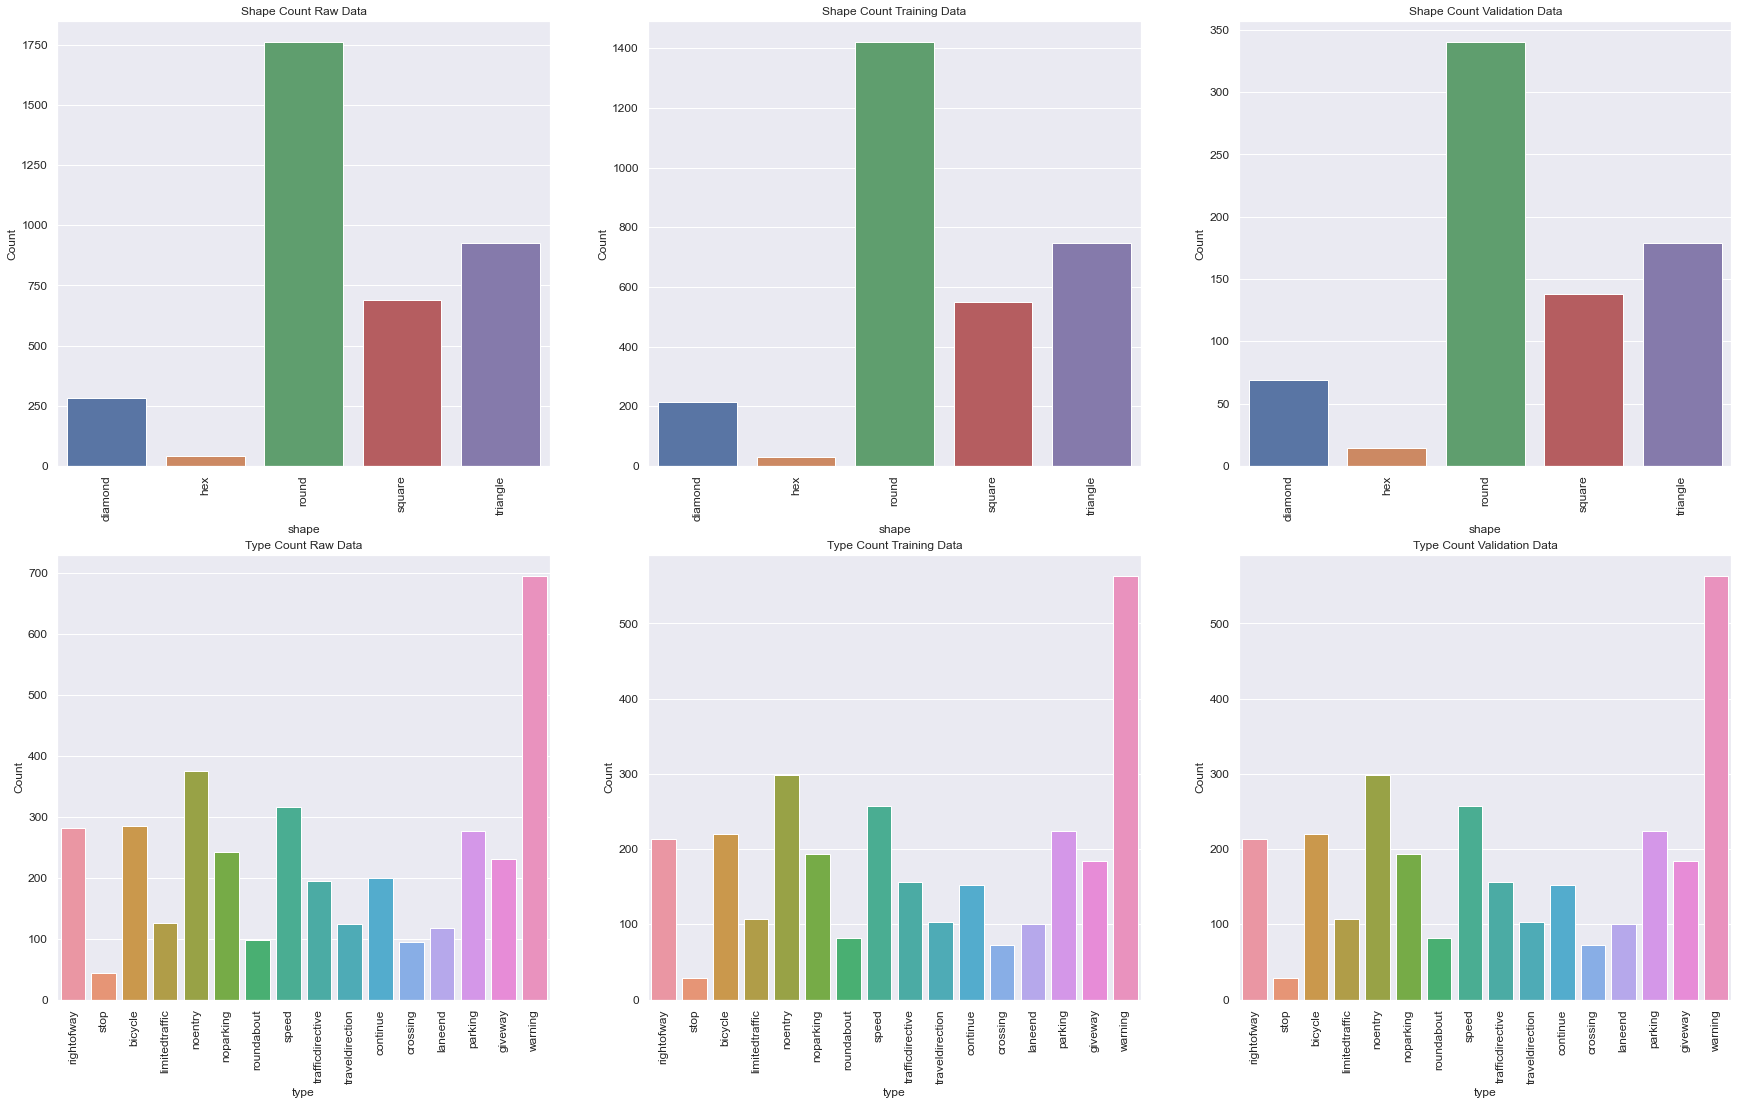

In [6]:
# Check Distribution of classes in training data splits compared to raw

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(2,3, figsize=(30,18))

make_subplot(x="shape",data=raw_data, order=SHAPE_NAMES, ax=ax[0,0], title="Shape Count Raw Data")
make_subplot(x="shape",data=shape_train_data, order=SHAPE_NAMES, ax=ax[0,1], title="Shape Count Training Data")
make_subplot(x="shape",data=shape_val_data, order=SHAPE_NAMES, ax=ax[0,2], title="Shape Count Validation Data")
make_subplot(x="type",data=raw_data, order=TYPE_NAMES, ax=ax[1,0], title="Type Count Raw Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,1], title="Type Count Training Data")
make_subplot(x="type",data=type_train_data, order=TYPE_NAMES, ax=ax[1,2], title="Type Count Validation Data")


# Modelling & Evaluation

In [6]:
class CNNModel:

    def __init__(self):
        self.epochs = 100

    def create_data_generator(self, df,datagen,batch_size,target,target_size=(28,28)):
        print(target_size)
        generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory = './',
            x_col='filepath',
            y_col=target,
            target_size=target_size,
            batch_size=batch_size,
            color_mode="grayscale",
            class_mode='categorical'
        )

        return generator

    def build_vgg_model(self, num_classes):

        self.model = tf.keras.Sequential([
            #VGG block 1
            tf.keras.layers.Conv2D(DIM, (3, 3), activation='relu', padding='same', input_shape=(DIM, DIM, NUM_BANDS)),
            tf.keras.layers.Conv2D(DIM, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 2
            tf.keras.layers.Conv2D(DIM*2, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(DIM*2, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            #VGG block 3
            tf.keras.layers.Conv2D(DIM*4, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(DIM*4, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(DIM*4, activation='relu'),
            tf.keras.layers.Dense(num_classes)
        ])

    def build_resnet_model(self,num_classes):
        self.model = ResNet50(input_shape=(RES_DIM,RES_DIM,NUM_BANDS), num_classes=num_classes)

    def compile_resnet_model(self):
        self.model.compile(optimizer="adam", 
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
            metrics=["categorical_accuracy"])
    
    def compile_vgg_model(self):
        self.model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['categorical_accuracy'])

    def fit_model(self):
       return self.model.fit_generator(self.train_generator, validation_data=self.val_generator,\
           epochs=self.epochs,verbose=1)
    

### Baseline Model
VGG Baseline Model


In [8]:
shape_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
shape_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

type_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
type_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

# RESNET PAPER USED Batch Size DIM*4. Batchsize to be updated later (Impact on Run Time)
vgg_batch_size = 32


vgg_shape_model = CNNModel()
vgg_type_model = CNNModel()


# Baseline VGG Shape Model Data Generators
vgg_shape_model.train_generator = vgg_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,vgg_batch_size,"shape")

vgg_shape_model.val_generator = vgg_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,vgg_batch_size,"shape")

# Baseline VGG Type Model Data Generators
vgg_type_model.train_generator = vgg_type_model.create_data_generator(\
    type_train_data,type_train_datagen,vgg_batch_size,"type")

vgg_type_model.val_generator = vgg_type_model.create_data_generator(\
    type_val_data,type_val_datagen,vgg_batch_size,"type")



(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.
(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


In [9]:
# Build Model
vgg_shape_model.build_vgg_model(TOTAL_SHAPES)
vgg_type_model.build_vgg_model(TOTAL_TYPES)

In [10]:
vgg_shape_model.compile_vgg_model()
vgg_type_model.compile_vgg_model()

vgg_shape_fit = vgg_shape_model.fit_model()
vgg_type_fit = vgg_type_model.fit_model()

c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - 22s 144ms/step - loss: 0.8685 - categorical_accuracy: 0.6850 - val_loss: 0.3050 - val_categorical_accuracy: 0.9149
Epoch 2/100
93/93 [==============================] - 1s 13ms/step - loss: 0.1532 - categorical_accuracy: 0.9564 - val_loss: 0.0992 - val_categorical_accuracy: 0.9730
Epoch 3/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0525 - categorical_accuracy: 0.9851 - val_loss: 0.0522 - val_categorical_accuracy: 0.9811
Epoch 4/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0316 - categorical_accuracy: 0.9888 - val_loss: 0.0354 - val_categorical_accuracy: 0.9919
Epoch 5/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0250 - categorical_accuracy: 0.9929 - val_loss: 0.0318 - val_categorical_accuracy: 0.9865
Epoch 6/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0120 - categorical_accuracy: 0.9963 - val_loss: 0.0241 - val_categorical_accuracy: 0.9932
Ep

In [22]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy', title=None):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)
    plt.show()

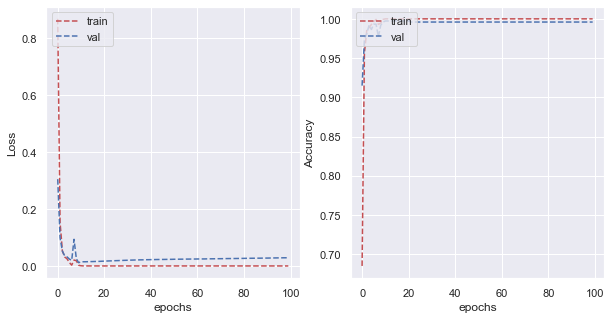

In [12]:
plot_learning_curve(vgg_shape_fit.history['loss'], vgg_shape_fit.history['val_loss'], 
                    vgg_shape_fit.history['categorical_accuracy'], vgg_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

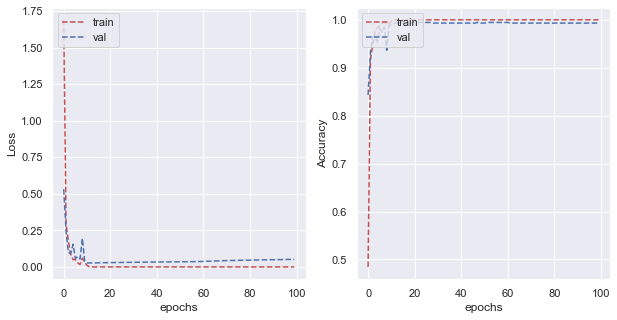

In [13]:
plot_learning_curve(vgg_type_fit.history['loss'], vgg_type_fit.history['val_loss'], 
                    vgg_type_fit.history['categorical_accuracy'], vgg_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Resnet Model
https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb


In [15]:
# identity block -> standard block used in ResNets 
def identity_block(X, f, filters, stage, block):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # save current input tensor
    X_save = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=-1, name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2c")(X)

    # add shorcut connection to main path 
    X = Add()([X, X_save])
    X = Activation("relu")(X)

    return X
    

In [16]:
# convolutional block -> standard block used in ResNets to ensure input and ouptut dimension
def convolutional_block(X, f, filters, stage, block, s=2):
    '''
    identity blocks are required to transform into a residual network 
    inputs:
    X -> input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -> integer determining the shape of the middle CONV's window
    filters -> list of integers, defines number of filters in the CONV layer 
    stage -> integer, names the layers depending on position in NN
    block -> string, used to name the layers, depending on their position in the network
    s -> integer, specifies the stride to be used, i.e. to reduce the dimension by a factor of 2, use a stride of 2

    outputs:
    X -> the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    # defines the name of branch according to current position
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # retrieve the filters to apply
    F1, F2, F3 = filters

    # to build shortcut path
    X_shortcut = X 

    # first component 
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    # normalises the channels axis
    X = BatchNormalization(axis=-1, name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)

    # second component
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)

    # third component
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid", name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+"2c")(X)

    # build the shortcut path 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid", name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+"1")(X_shortcut)


    # add shortcut connection to main path 
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

In [17]:
# 50 layer ResNet Model
def ResNet50(num_classes, input_shape=(DIM,DIM,NUM_BANDS)):
    '''
    ResNet50 Architecture follows:
    (stage 1) = CONV2D -> BN -> RELU -> MAXPOOL -> 
    stage 2 = CONVBLOCK -> IDBLOCK x 2 -> 
    stage 3 = CONVBLOCK -> IDBLOCK X 3 -> 
    stage 4 = CONVBLOCK -> IDBLOCK X 5 -> 
    # stage 5 = CONVBLOCK -> IDBLOCK x 2 -> 
    (stage 6) = AVGPOOL -> TOP LAYER

    inputs:
    input_shape -> shape of images in dataset 
    classes -> number of classes to predict

    outputs:
    model -> a Keras Model() instance for training
    '''
    # set the input shape
    X_input = Input(input_shape)

    # initialise the zero padding
    X = ZeroPadding2D((3,3))(X_input)

    # implement the architecture
    X = Conv2D(DIM, (7,7), strides=(2,2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)

    X = convolutional_block(X, f=3, filters=[DIM,DIM,DIM*4], stage=2, block="a", s=1)
    X = identity_block(X, 3, [DIM,DIM,DIM*4], stage=2, block="b")
    X = identity_block(X, 3, [DIM,DIM,DIM*4], stage=2, block="c")

    X = convolutional_block(X, f=3, filters=[DIM*2,DIM*2,DIM*8], stage=3, block="a", s=2)
    X = identity_block(X, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="b")
    X = identity_block(X, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="c")
    X = identity_block(X, 3, [DIM*2,DIM*2,DIM*8], stage=3, block="d")

    X = convolutional_block(X, f=3, filters=[DIM*4,DIM*4,DIM*16], stage=4, block="a", s=2)
    X = identity_block(X, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="b")
    X = identity_block(X, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="c")
    X = identity_block(X, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="d")
    X = identity_block(X, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="e")
    X = identity_block(X, 3, [DIM*4,DIM*4,DIM*16], stage=4, block="f")

    # X = convolutional_block(X, f=3, filters=[DIM*8,DIM*8,DIM*32], stage=5, block="a", s=2)
    # X = identity_block(X, 3, [DIM*8,DIM*8,DIM*32], stage=5, block="b")
    # X = identity_block(X, 3, [DIM*8,DIM*8,DIM*32], stage=5, block="c")

    X = AveragePooling2D((2,2), name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(num_classes, activation="softmax", name="fc"+str(num_classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # create the resnet model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

In [17]:
resnet_batch_size = 32
resnet_target_size=(RES_DIM,RES_DIM)

resnet_shape_model = CNNModel()
resnet_type_model = CNNModel()


# Baseline Resnet50 Shape Model Data Generators
resnet_shape_model.train_generator = resnet_shape_model.create_data_generator(\
    shape_train_data,shape_train_datagen,resnet_batch_size,"shape",target_size=resnet_target_size)

resnet_shape_model.val_generator = resnet_shape_model.create_data_generator(\
    shape_val_data,shape_val_datagen,resnet_batch_size,"shape",target_size=resnet_target_size)

# Baseline Resnet50 Type Model Data Generators
resnet_type_model.train_generator = resnet_type_model.create_data_generator(\
    type_train_data,type_train_datagen,resnet_batch_size,"type",target_size=resnet_target_size)

resnet_type_model.val_generator = resnet_type_model.create_data_generator(\
    type_val_data,type_val_datagen,resnet_batch_size,"type",target_size=resnet_target_size)


# Build Model
resnet_shape_model.build_resnet_model(TOTAL_SHAPES)
resnet_type_model.build_resnet_model(TOTAL_TYPES)

# Compile Model
resnet_shape_model.compile_resnet_model()
resnet_type_model.compile_resnet_model()

# Fit Model
resnet_shape_fit = resnet_shape_model.fit_model()
resnet_type_fit = resnet_type_model.fit_model()

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.
(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - 9s 47ms/step - loss: 1.3287 - categorical_accuracy: 0.6495 - val_loss: 1.5846 - val_categorical_accuracy: 0.4662
Epoch 2/100
93/93 [==============================] - 3s 37ms/step - loss: 0.3258 - categorical_accuracy: 0.8942 - val_loss: 1.2674 - val_categorical_accuracy: 0.4595
Epoch 3/100
93/93 [==============================] - 3s 36ms/step - loss: 0.1751 - categorical_accuracy: 0.9432 - val_loss: 1.0419 - val_categorical_accuracy: 0.6324
Epoch 4/100
93/93 [==============================] - 3s 37ms/step - loss: 0.1286 - categorical_accuracy: 0.9561 - val_loss: 0.8746 - val_categorical_accuracy: 0.7324
Epoch 5/100
93/93 [==============================] - 3s 37ms/step - loss: 0.0979 - categorical_accuracy: 0.9689 - val_loss: 0.5061 - val_categorical_accuracy: 0.8595
Epoch 6/100
93/93 [==============================] - 3s 36ms/step - loss: 0.0847 - categorical_accuracy: 0.9747 - val_loss: 0.2593 - val_categorical_accuracy: 0.9149
Epoc

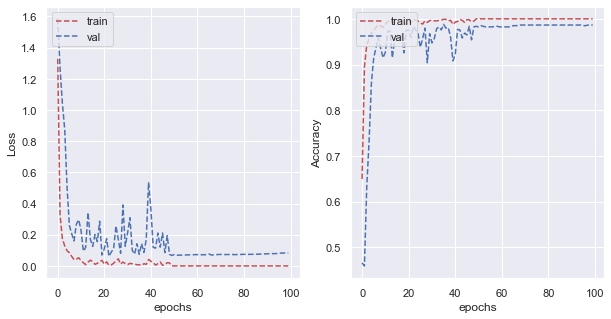

In [18]:
plot_learning_curve(resnet_shape_fit.history['loss'], resnet_shape_fit.history['val_loss'], 
                    resnet_shape_fit.history['categorical_accuracy'], resnet_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

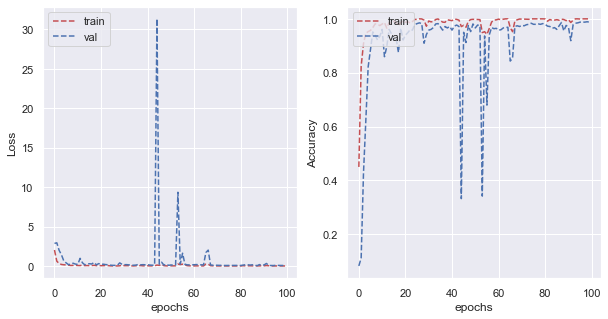

In [19]:
plot_learning_curve(resnet_type_fit.history['loss'], resnet_type_fit.history['val_loss'], 
                    resnet_type_fit.history['categorical_accuracy'], resnet_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [20]:
# tf.keras.utils.plot_model(resnet_shape_model.model, show_shapes=True)

# Hyper-Parameter Tuning - VGG Type as better than initial ResNet Type model

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/296 [==============================] - 3s 9ms/step - loss: 1.4681 - categorical_accuracy: 0.5603 - val_loss: 0.4676 - val_categorical_accuracy: 0.8581
Epoch 2/10
296/296 [==============================] - 2s 8ms/step - loss: 0.3218 - categorical_accuracy: 0.9067 - val_loss: 0.3157 - val_categorical_accuracy: 0.8905
Epoch 3/10
296/296 [==============================] - 2s 8ms/step - loss: 0.1487 - categorical_accuracy: 0.9601 - val_loss: 0.2398 - val_categorical_accuracy: 0.9135
Epoch 4/10
296/296 [==============================] - 2s 8ms/step - loss: 0.0855 - categorical_accuracy: 0.9730 - val_loss: 0.1502 - val_categorical_accuracy: 0.9405
Epoch 5/10
296/296 [==============================] - 2s 8ms/step - loss: 0.0628 - categorical_accuracy: 0.9831 - val_loss: 0.0570 - val_categorical_accuracy: 0.9784
Epoch 6/10
296/296 [==============================] - 2s 8ms/step - loss: 0.0385 - categorical_accuracy: 0.9882 - val_loss: 0.1090 - val_categorical_accuracy: 0.9716
Epoc

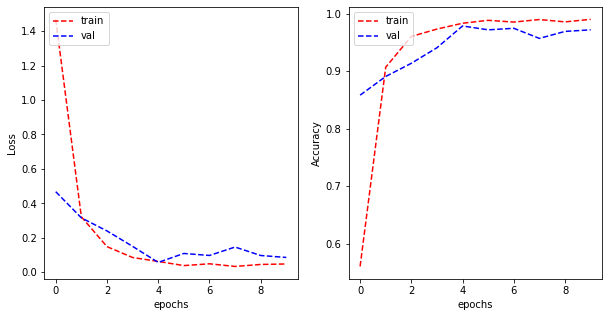

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
296/296 [==============================] - 3s 8ms/step - loss: 1.3681 - categorical_accuracy: 0.5928 - val_loss: 0.3193 - val_categorical_accuracy: 0.9041
Epoch 2/50
296/296 [==============================] - 2s 8ms/step - loss: 0.2415 - categorical_accuracy: 0.9273 - val_loss: 0.1282 - val_categorical_accuracy: 0.9622
Epoch 3/50
296/296 [==============================] - 2s 8ms/step - loss: 0.1171 - categorical_accuracy: 0.9689 - val_loss: 0.1157 - val_categorical_accuracy: 0.9595
Epoch 4/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0829 - categorical_accuracy: 0.9740 - val_loss: 0.1201 - val_categorical_accuracy: 0.9676
Epoch 5/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0636 - categorical_accuracy: 0.9804 - val_loss: 0.1508 - val_categorical_accuracy: 0.9541
Epoch 6/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0305 - categorical_accuracy: 0.9905 - val_loss: 0.1132 - val_categorical_accuracy: 0.9730
Epoc

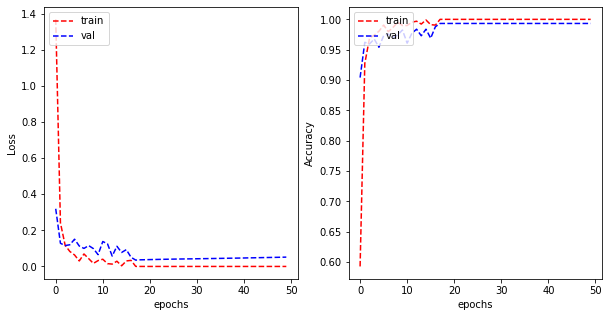

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
296/296 [==============================] - 3s 8ms/step - loss: 1.2936 - categorical_accuracy: 0.6144 - val_loss: 0.4320 - val_categorical_accuracy: 0.8730
Epoch 2/100
296/296 [==============================] - 2s 8ms/step - loss: 0.2823 - categorical_accuracy: 0.9226 - val_loss: 0.1685 - val_categorical_accuracy: 0.9500
Epoch 3/100
296/296 [==============================] - 2s 8ms/step - loss: 0.1374 - categorical_accuracy: 0.9567 - val_loss: 0.1177 - val_categorical_accuracy: 0.9649
Epoch 4/100
296/296 [==============================] - 2s 8ms/step - loss: 0.0752 - categorical_accuracy: 0.9757 - val_loss: 0.0785 - val_categorical_accuracy: 0.9797
Epoch 5/100
296/296 [==============================] - 2s 7ms/step - loss: 0.0535 - categorical_accuracy: 0.9845 - val_loss: 0.1202 - val_categorical_accuracy: 0.9703
Epoch 6/100
296/296 [==============================] - 2s 8ms/step - loss: 0.0465 - categorical_accuracy: 0.9875 - val_loss: 0.0814 - val_categorical_accuracy: 0.979

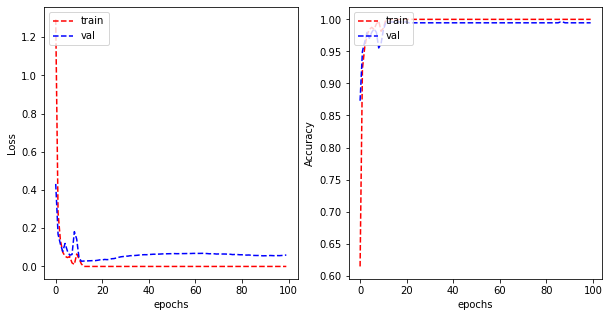

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


148/148 [==============================] - 2s 11ms/step - loss: 1.5280 - categorical_accuracy: 0.5373 - val_loss: 0.3846 - val_categorical_accuracy: 0.8851
Epoch 2/10
148/148 [==============================] - 1s 9ms/step - loss: 0.2845 - categorical_accuracy: 0.9206 - val_loss: 0.1907 - val_categorical_accuracy: 0.9405
Epoch 3/10
148/148 [==============================] - 1s 9ms/step - loss: 0.1406 - categorical_accuracy: 0.9601 - val_loss: 0.0873 - val_categorical_accuracy: 0.9757
Epoch 4/10
148/148 [==============================] - 1s 9ms/step - loss: 0.0774 - categorical_accuracy: 0.9780 - val_loss: 0.0981 - val_categorical_accuracy: 0.9662
Epoch 5/10
148/148 [==============================] - 1s 9ms/step - loss: 0.0656 - categorical_accuracy: 0.9774 - val_loss: 0.0806 - val_categorical_accuracy: 0.9730
Epoch 6/10
148/148 [==============================] - 1s 9ms/step - loss: 0.0622 - categorical_accuracy: 0.9818 - val_loss: 0.0871 - val_categorical_accuracy: 0.9730
Epoch 7/10
148

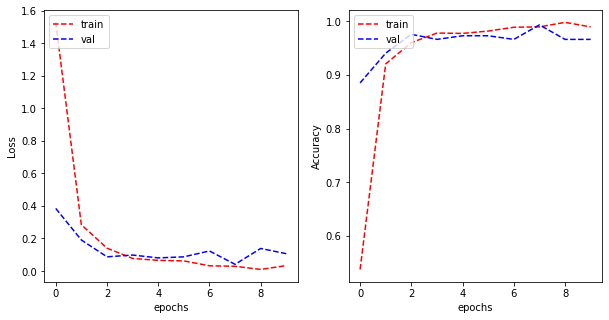

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/50


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


148/148 [==============================] - 2s 10ms/step - loss: 1.4055 - categorical_accuracy: 0.5759 - val_loss: 0.5084 - val_categorical_accuracy: 0.8297
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.2447 - categorical_accuracy: 0.9284 - val_loss: 0.1425 - val_categorical_accuracy: 0.9581
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 0.1059 - categorical_accuracy: 0.9682 - val_loss: 0.1924 - val_categorical_accuracy: 0.9473
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0815 - categorical_accuracy: 0.9733 - val_loss: 0.1304 - val_categorical_accuracy: 0.9608
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0613 - categorical_accuracy: 0.9804 - val_loss: 0.1430 - val_categorical_accuracy: 0.9581
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.0401 - categorical_accuracy: 0.9919 - val_loss: 0.0581 - val_categorical_accuracy: 0.9851
Epoch 7/50
148

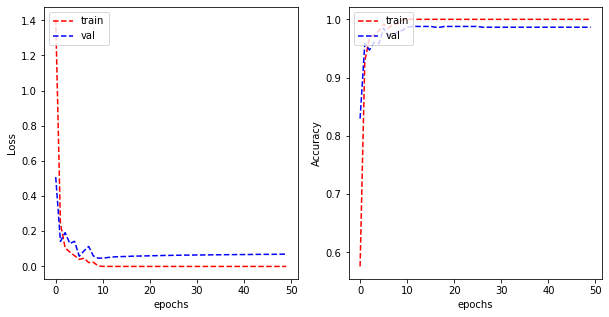

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/100


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


148/148 [==============================] - 2s 10ms/step - loss: 1.6351 - categorical_accuracy: 0.4924 - val_loss: 0.5675 - val_categorical_accuracy: 0.8257
Epoch 2/100
148/148 [==============================] - 1s 9ms/step - loss: 0.3027 - categorical_accuracy: 0.9138 - val_loss: 0.1932 - val_categorical_accuracy: 0.9486
Epoch 3/100
148/148 [==============================] - 1s 9ms/step - loss: 0.1375 - categorical_accuracy: 0.9584 - val_loss: 0.1228 - val_categorical_accuracy: 0.9689
Epoch 4/100
148/148 [==============================] - 1s 9ms/step - loss: 0.0725 - categorical_accuracy: 0.9784 - val_loss: 0.1744 - val_categorical_accuracy: 0.9446
Epoch 5/100
148/148 [==============================] - 1s 9ms/step - loss: 0.0665 - categorical_accuracy: 0.9784 - val_loss: 0.1604 - val_categorical_accuracy: 0.9486
Epoch 6/100
148/148 [==============================] - 1s 9ms/step - loss: 0.0416 - categorical_accuracy: 0.9865 - val_loss: 0.0874 - val_categorical_accuracy: 0.9703
Epoch 7/1

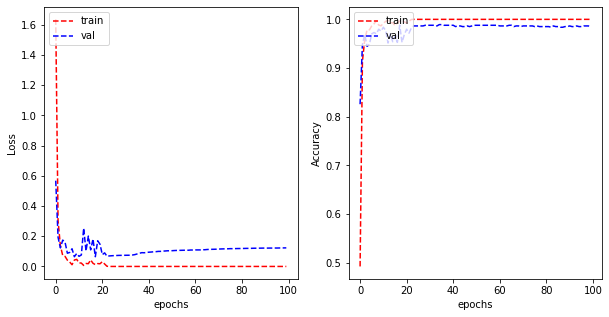

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
74/74 [==============================] - 2s 19ms/step - loss: 1.8149 - categorical_accuracy: 0.4640 - val_loss: 0.8184 - val_categorical_accuracy: 0.7419
Epoch 2/10
74/74 [==============================] - 1s 15ms/step - loss: 0.4414 - categorical_accuracy: 0.8807 - val_loss: 0.3096 - val_categorical_accuracy: 0.9135
Epoch 3/10
74/74 [==============================] - 1s 15ms/step - loss: 0.1984 - categorical_accuracy: 0.9395 - val_loss: 0.2525 - val_categorical_accuracy: 0.9243
Epoch 4/10
74/74 [==============================] - 1s 15ms/step - loss: 0.1131 - categorical_accuracy: 0.9692 - val_loss: 0.1598 - val_categorical_accuracy: 0.9514
Epoch 5/10
74/74 [==============================] - 1s 15ms/step - loss: 0.0560 - categorical_accuracy: 0.9841 - val_loss: 0.1211 - val_categorical_accuracy: 0.9649
Epoch 6/10
74/74 [==============================] - 1s 16ms/step - loss: 0.0219 - categorical_accuracy: 0.9922 - val_loss: 0.1858 - val_categorical_accuracy: 0.9608
Epoch 7/10

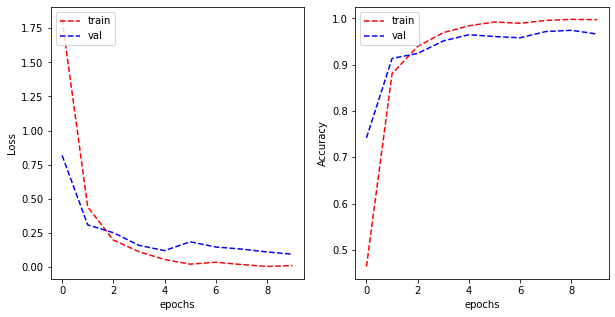

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/50


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


74/74 [==============================] - 2s 17ms/step - loss: 1.8420 - categorical_accuracy: 0.4525 - val_loss: 0.6136 - val_categorical_accuracy: 0.8270
Epoch 2/50
74/74 [==============================] - 1s 15ms/step - loss: 0.3781 - categorical_accuracy: 0.8949 - val_loss: 0.2575 - val_categorical_accuracy: 0.9135
Epoch 3/50
74/74 [==============================] - 1s 15ms/step - loss: 0.1657 - categorical_accuracy: 0.9530 - val_loss: 0.1457 - val_categorical_accuracy: 0.9581
Epoch 4/50
74/74 [==============================] - 1s 15ms/step - loss: 0.0836 - categorical_accuracy: 0.9767 - val_loss: 0.0972 - val_categorical_accuracy: 0.9689
Epoch 5/50
74/74 [==============================] - 1s 15ms/step - loss: 0.0548 - categorical_accuracy: 0.9818 - val_loss: 0.1740 - val_categorical_accuracy: 0.9500
Epoch 6/50
74/74 [==============================] - 1s 15ms/step - loss: 0.0493 - categorical_accuracy: 0.9834 - val_loss: 0.1090 - val_categorical_accuracy: 0.9689
Epoch 7/50
74/74 [===

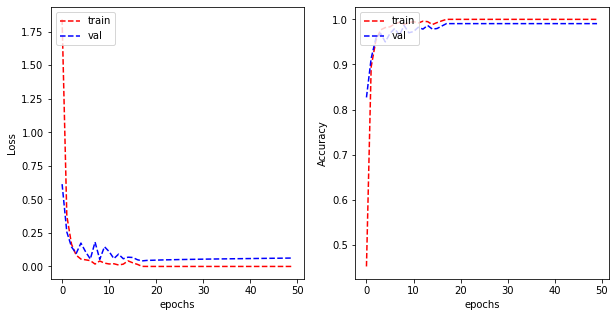

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
74/74 [==============================] - 2s 17ms/step - loss: 2.0090 - categorical_accuracy: 0.3792 - val_loss: 0.8318 - val_categorical_accuracy: 0.7757
Epoch 2/100
74/74 [==============================] - 1s 15ms/step - loss: 0.4043 - categorical_accuracy: 0.8810 - val_loss: 0.2478 - val_categorical_accuracy: 0.9081
Epoch 3/100
74/74 [==============================] - 1s 15ms/step - loss: 0.1620 - categorical_accuracy: 0.9547 - val_loss: 0.2078 - val_categorical_accuracy: 0.9365
Epoch 4/100
74/74 [==============================] - 1s 15ms/step - loss: 0.1074 - categorical_accuracy: 0.9649 - val_loss: 0.1118 - val_categorical_accuracy: 0.9716
Epoch 5/100
74/74 [==============================] - 1s 15ms/step - loss: 0.0609 - categorical_accuracy: 0.9801 - val_loss: 0.1065 - val_categorical_accuracy: 0.9703
Epoch 6/100
74/74 [==============================] - 1s 15ms/step - loss: 0.0236 - categorical_accuracy: 0.9932 - val_loss: 0.0468 - val_categorical_accuracy: 0.9851
Epoc

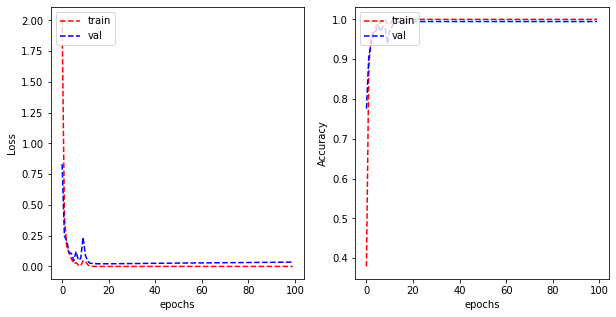

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 2s 24ms/step - loss: 1.9617 - categorical_accuracy: 0.4191 - val_loss: 0.8917 - val_categorical_accuracy: 0.7311
Epoch 2/10
50/50 [==============================] - 1s 21ms/step - loss: 0.4793 - categorical_accuracy: 0.8628 - val_loss: 0.2760 - val_categorical_accuracy: 0.9068
Epoch 3/10
50/50 [==============================] - 1s 21ms/step - loss: 0.1889 - categorical_accuracy: 0.9486 - val_loss: 0.1638 - val_categorical_accuracy: 0.9568
Epoch 4/10
50/50 [==============================] - 1s 21ms/step - loss: 0.1080 - categorical_accuracy: 0.9709 - val_loss: 0.1518 - val_categorical_accuracy: 0.9541
Epoch 5/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0665 - categorical_accuracy: 0.9807 - val_loss: 0.1452 - val_categorical_accuracy: 0.9581
Epoch 6/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0573 - categorical_accuracy: 0.9828 - val_loss: 0.1036 - val_categorical_accuracy: 0.9676
Epoch 7/10
50/50 [===

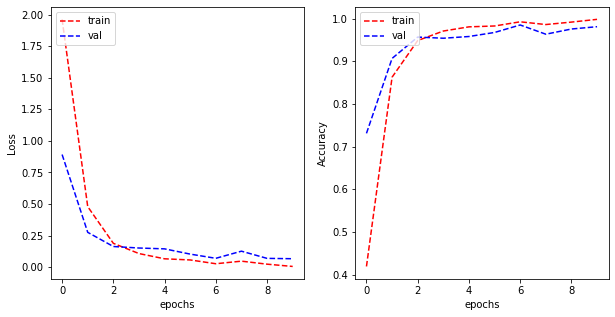

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/50


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 2s 24ms/step - loss: 2.2896 - categorical_accuracy: 0.3031 - val_loss: 1.4337 - val_categorical_accuracy: 0.5459
Epoch 2/50
50/50 [==============================] - 1s 22ms/step - loss: 0.6474 - categorical_accuracy: 0.8131 - val_loss: 0.3525 - val_categorical_accuracy: 0.8946
Epoch 3/50
50/50 [==============================] - 1s 21ms/step - loss: 0.2296 - categorical_accuracy: 0.9344 - val_loss: 0.1862 - val_categorical_accuracy: 0.9486
Epoch 4/50
50/50 [==============================] - 1s 20ms/step - loss: 0.1317 - categorical_accuracy: 0.9642 - val_loss: 0.1189 - val_categorical_accuracy: 0.9635
Epoch 5/50
50/50 [==============================] - 1s 21ms/step - loss: 0.1341 - categorical_accuracy: 0.9621 - val_loss: 0.1008 - val_categorical_accuracy: 0.9743
Epoch 6/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0530 - categorical_accuracy: 0.9845 - val_loss: 0.0884 - val_categorical_accuracy: 0.9716
Epoch 7/50
50/50 [===

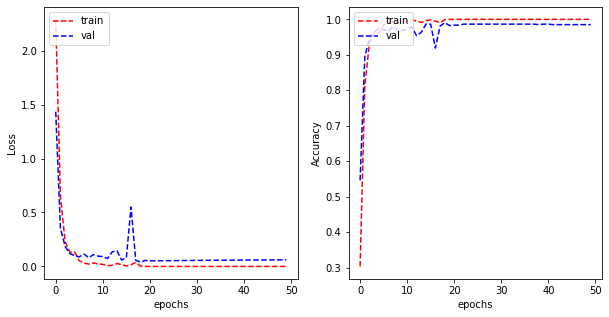

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/100


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 2s 25ms/step - loss: 2.4528 - categorical_accuracy: 0.2372 - val_loss: 1.7386 - val_categorical_accuracy: 0.5419
Epoch 2/100
50/50 [==============================] - 1s 21ms/step - loss: 0.9021 - categorical_accuracy: 0.7452 - val_loss: 0.4934 - val_categorical_accuracy: 0.8351
Epoch 3/100
50/50 [==============================] - 1s 22ms/step - loss: 0.2997 - categorical_accuracy: 0.9148 - val_loss: 0.2502 - val_categorical_accuracy: 0.9203
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 0.1380 - categorical_accuracy: 0.9601 - val_loss: 0.1595 - val_categorical_accuracy: 0.9486
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 0.1025 - categorical_accuracy: 0.9686 - val_loss: 0.1336 - val_categorical_accuracy: 0.9595
Epoch 6/100
50/50 [==============================] - 1s 21ms/step - loss: 0.0445 - categorical_accuracy: 0.9834 - val_loss: 0.1353 - val_categorical_accuracy: 0.9541
Epoch 7/100
50/5

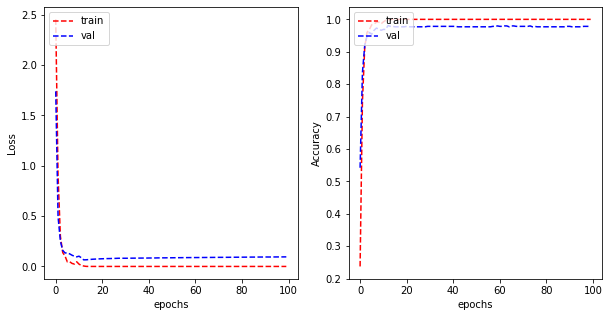

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37/37 [==============================] - 2s 36ms/step - loss: 2.5645 - categorical_accuracy: 0.2051 - val_loss: 2.1639 - val_categorical_accuracy: 0.3622
Epoch 2/10
37/37 [==============================] - 1s 28ms/step - loss: 1.2559 - categorical_accuracy: 0.6448 - val_loss: 0.6858 - val_categorical_accuracy: 0.8041
Epoch 3/10
37/37 [==============================] - 1s 28ms/step - loss: 0.3926 - categorical_accuracy: 0.8912 - val_loss: 0.2879 - val_categorical_accuracy: 0.9176
Epoch 4/10
37/37 [==============================] - 1s 28ms/step - loss: 0.2085 - categorical_accuracy: 0.9358 - val_loss: 0.1891 - val_categorical_accuracy: 0.9338
Epoch 5/10
37/37 [==============================] - 1s 28ms/step - loss: 0.1140 - categorical_accuracy: 0.9618 - val_loss: 0.1864 - val_categorical_accuracy: 0.9365
Epoch 6/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0967 - categorical_accuracy: 0.9699 - val_loss: 0.1009 - val_categorical_accuracy: 0.9649
Epoch 7/10
37/37 [===

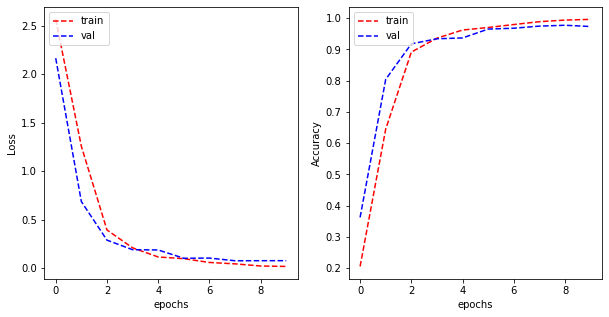

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/50


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37/37 [==============================] - 2s 33ms/step - loss: 2.1879 - categorical_accuracy: 0.3434 - val_loss: 1.3811 - val_categorical_accuracy: 0.6189
Epoch 2/50
37/37 [==============================] - 1s 28ms/step - loss: 0.7368 - categorical_accuracy: 0.8091 - val_loss: 0.4641 - val_categorical_accuracy: 0.8676
Epoch 3/50
37/37 [==============================] - 1s 28ms/step - loss: 0.3018 - categorical_accuracy: 0.9189 - val_loss: 0.2592 - val_categorical_accuracy: 0.9162
Epoch 4/50
37/37 [==============================] - 1s 28ms/step - loss: 0.1527 - categorical_accuracy: 0.9557 - val_loss: 0.1591 - val_categorical_accuracy: 0.9500
Epoch 5/50
37/37 [==============================] - 1s 28ms/step - loss: 0.0859 - categorical_accuracy: 0.9743 - val_loss: 0.1099 - val_categorical_accuracy: 0.9622
Epoch 6/50
37/37 [==============================] - 1s 28ms/step - loss: 0.0641 - categorical_accuracy: 0.9790 - val_loss: 0.1021 - val_categorical_accuracy: 0.9676
Epoch 7/50
37/37 [===

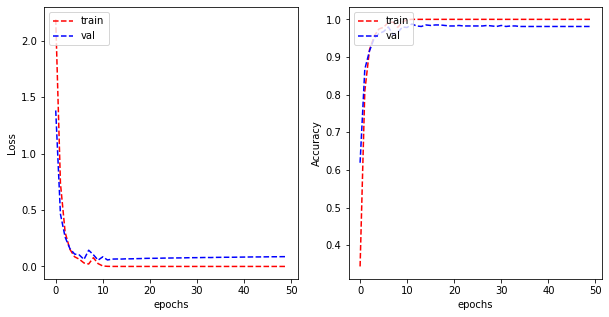

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/100


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37/37 [==============================] - 2s 33ms/step - loss: 2.3098 - categorical_accuracy: 0.2964 - val_loss: 1.5213 - val_categorical_accuracy: 0.5959
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.8805 - categorical_accuracy: 0.7513 - val_loss: 0.5904 - val_categorical_accuracy: 0.8054
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3383 - categorical_accuracy: 0.9047 - val_loss: 0.2996 - val_categorical_accuracy: 0.9149
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.1734 - categorical_accuracy: 0.9537 - val_loss: 0.1718 - val_categorical_accuracy: 0.9514
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.0991 - categorical_accuracy: 0.9682 - val_loss: 0.1627 - val_categorical_accuracy: 0.9486
Epoch 6/100
37/37 [==============================] - 1s 28ms/step - loss: 0.0528 - categorical_accuracy: 0.9858 - val_loss: 0.1263 - val_categorical_accuracy: 0.9635
Epoch 7/100
37/3

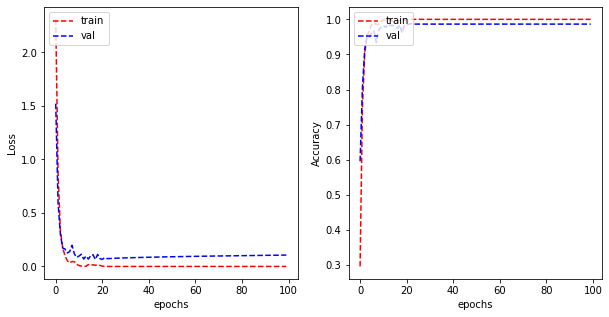

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/10


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 2s 51ms/step - loss: 2.4635 - categorical_accuracy: 0.2261 - val_loss: 1.8361 - val_categorical_accuracy: 0.5284
Epoch 2/10
30/30 [==============================] - 1s 36ms/step - loss: 1.2237 - categorical_accuracy: 0.6485 - val_loss: 0.7242 - val_categorical_accuracy: 0.7676
Epoch 3/10
30/30 [==============================] - 1s 35ms/step - loss: 0.5069 - categorical_accuracy: 0.8527 - val_loss: 0.3982 - val_categorical_accuracy: 0.8878
Epoch 4/10
30/30 [==============================] - 1s 35ms/step - loss: 0.2230 - categorical_accuracy: 0.9392 - val_loss: 0.1986 - val_categorical_accuracy: 0.9486
Epoch 5/10
30/30 [==============================] - 1s 35ms/step - loss: 0.1219 - categorical_accuracy: 0.9635 - val_loss: 0.1125 - val_categorical_accuracy: 0.9743
Epoch 6/10
30/30 [==============================] - 1s 36ms/step - loss: 0.0743 - categorical_accuracy: 0.9767 - val_loss: 0.1262 - val_categorical_accuracy: 0.9676
Epoch 7/10
30/30 [===

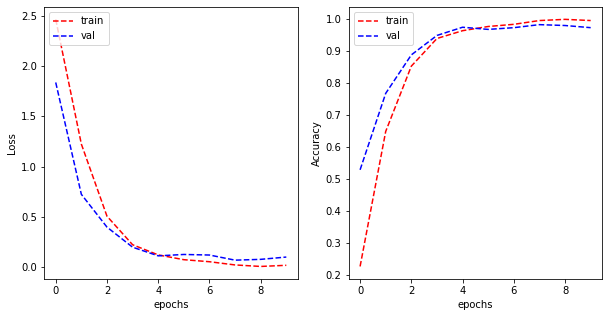

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 2s 41ms/step - loss: 2.5133 - categorical_accuracy: 0.2065 - val_loss: 2.0877 - val_categorical_accuracy: 0.3432
Epoch 2/50
30/30 [==============================] - 1s 35ms/step - loss: 1.2019 - categorical_accuracy: 0.6604 - val_loss: 0.6274 - val_categorical_accuracy: 0.8257
Epoch 3/50
30/30 [==============================] - 1s 34ms/step - loss: 0.4335 - categorical_accuracy: 0.8716 - val_loss: 0.3375 - val_categorical_accuracy: 0.9068
Epoch 4/50
30/30 [==============================] - 1s 34ms/step - loss: 0.2173 - categorical_accuracy: 0.9392 - val_loss: 0.2148 - val_categorical_accuracy: 0.9446
Epoch 5/50
30/30 [==============================] - 1s 34ms/step - loss: 0.1380 - categorical_accuracy: 0.9621 - val_loss: 0.1198 - val_categorical_accuracy: 0.9635
Epoch 6/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0806 - categorical_accuracy: 0.9743 - val_loss: 0.1312 - val_categorical_accuracy: 0.9595
Epoch 7/50

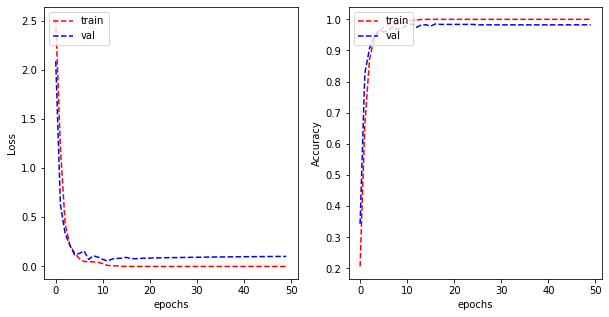

(28, 28)
Found 2959 validated image filenames belonging to 16 classes.
(28, 28)
Found 740 validated image filenames belonging to 16 classes.
Epoch 1/100


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


30/30 [==============================] - 2s 41ms/step - loss: 2.2775 - categorical_accuracy: 0.3254 - val_loss: 1.5693 - val_categorical_accuracy: 0.5851
Epoch 2/100
30/30 [==============================] - 1s 35ms/step - loss: 0.8717 - categorical_accuracy: 0.7519 - val_loss: 0.4546 - val_categorical_accuracy: 0.8378
Epoch 3/100
30/30 [==============================] - 1s 34ms/step - loss: 0.3538 - categorical_accuracy: 0.9030 - val_loss: 0.2412 - val_categorical_accuracy: 0.9230
Epoch 4/100
30/30 [==============================] - 1s 34ms/step - loss: 0.1510 - categorical_accuracy: 0.9571 - val_loss: 0.2559 - val_categorical_accuracy: 0.9149
Epoch 5/100
30/30 [==============================] - 1s 34ms/step - loss: 0.1114 - categorical_accuracy: 0.9669 - val_loss: 0.0884 - val_categorical_accuracy: 0.9730
Epoch 6/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0587 - categorical_accuracy: 0.9831 - val_loss: 0.1376 - val_categorical_accuracy: 0.9622
Epoch 7/100
30/3

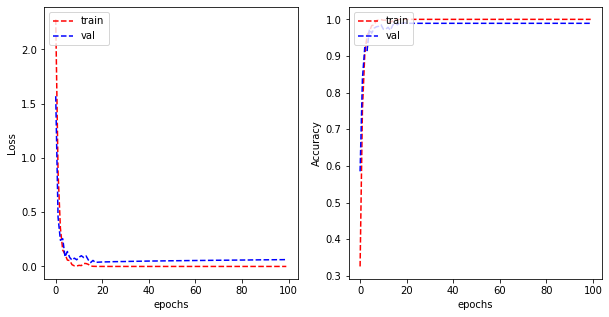

In [12]:
from sklearn.model_selection import ParameterGrid
# want to tune batch size, epochs
parameters = {"batch_size": [10, 20, 40, 60, 80, 100], "epochs" : [10, 50, 100]}

# save results of tuning for later accessing 
vgg_type_saved_results = {}
attempt = 0

# use parameter grid to generate permutations 
model_parameters = list(ParameterGrid(parameters))

for each in model_parameters:
    # need to tune batch size, so we initalise and build model + generator according to batch size
    type_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
    type_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

    vgg_type_model = CNNModel()

    # Baseline VGG Type Model Data Generators
    vgg_type_model.train_generator = vgg_type_model.create_data_generator(\
        type_train_data,type_train_datagen, each["batch_size"],"type")

    vgg_type_model.val_generator = vgg_type_model.create_data_generator(\
        type_val_data,type_val_datagen,each["batch_size"],"type")

    # build and compile the model for tuning 
    vgg_type_model.build_vgg_model(TOTAL_TYPES)
    vgg_type_model.compile_vgg_model()

    # fit the model 
    vgg_type_fit = vgg_type_model.model.fit_generator(vgg_type_model.train_generator, validation_data=vgg_type_model.val_generator,\
           epochs=each["epochs"],verbose=1)
    
    vgg_type_saved_results[attempt] = {"batch":each["batch_size"], "epoch":each["epochs"], "best_val_accuracy":max(vgg_type_fit.history["val_categorical_accuracy"]), \
        "loss":vgg_type_fit.history['loss'], "val_loss":vgg_type_fit.history['val_loss'], \
        "accuracy":vgg_type_fit.history['categorical_accuracy'], "val_accuracy":vgg_type_fit.history['val_categorical_accuracy']}
    attempt += 1
    print("For batch size {} and epochs of {}, performance:".format(each["batch_size"], each["epochs"]))
    plot_learning_curve(vgg_type_fit.history['loss'], vgg_type_fit.history['val_loss'], 
                    vgg_type_fit.history['categorical_accuracy'], vgg_type_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    

In [13]:
vgg_type_saved_results

{0: {'batch': 10,
  'epoch': 10,
  'best_val_accuracy': 0.9783783555030823,
  'loss': [1.4680986404418945,
   0.32179996371269226,
   0.14870361983776093,
   0.0854707583785057,
   0.06277551501989365,
   0.038539208471775055,
   0.04901454970240593,
   0.03359154239296913,
   0.045149389654397964,
   0.04798400402069092],
  'val_loss': [0.4675825238227844,
   0.31571871042251587,
   0.23982849717140198,
   0.15020592510700226,
   0.057008445262908936,
   0.1090102419257164,
   0.09736797958612442,
   0.14624084532260895,
   0.09711271524429321,
   0.08575394749641418],
  'accuracy': [0.5603244304656982,
   0.9067252278327942,
   0.9601216912269592,
   0.972963809967041,
   0.9831023812294006,
   0.9881716966629028,
   0.9851301312446594,
   0.9895234704017639,
   0.9854680895805359,
   0.9898614287376404],
  'val_accuracy': [0.8581081032752991,
   0.8905405402183533,
   0.9135135412216187,
   0.9405405521392822,
   0.9783783555030823,
   0.9716216325759888,
   0.9743243455886841,
   0

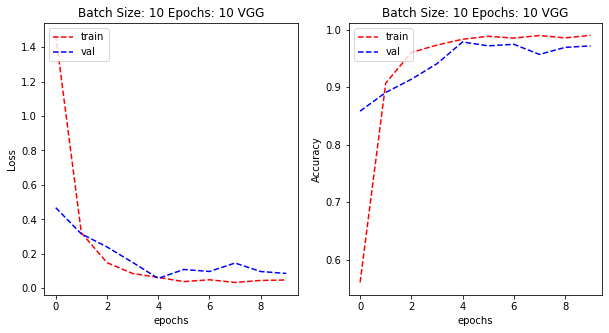

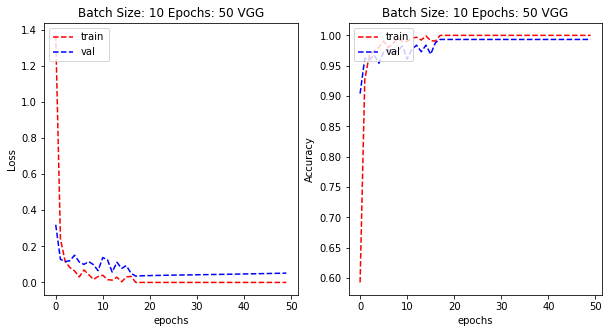

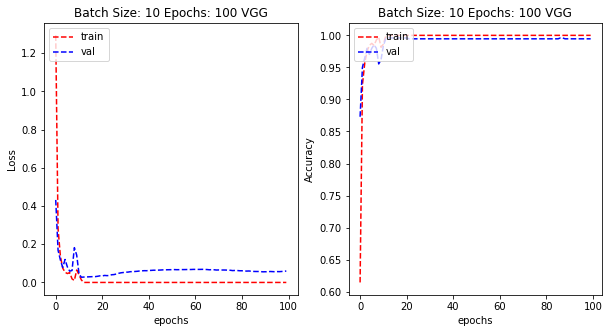

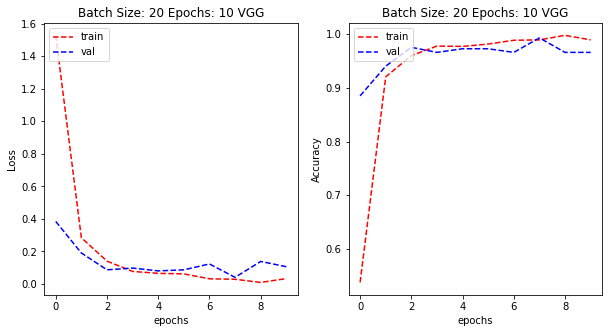

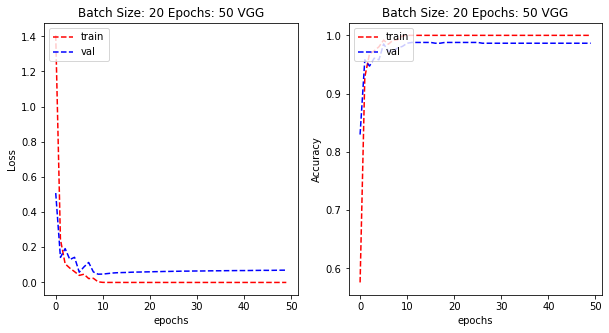

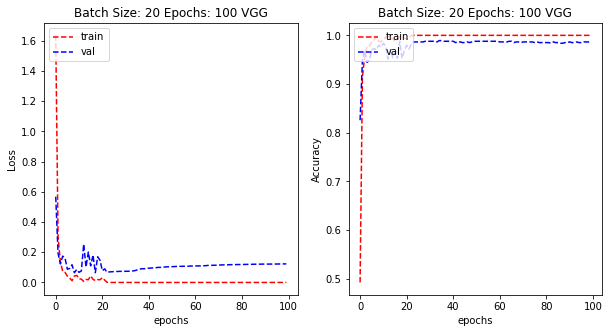

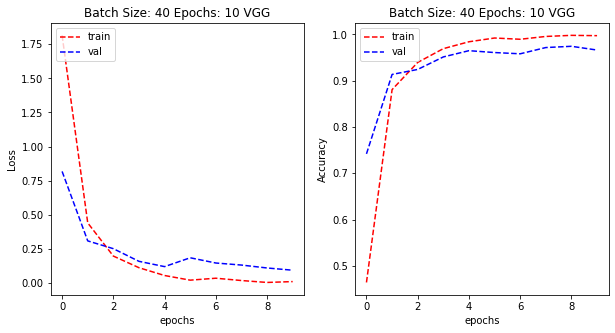

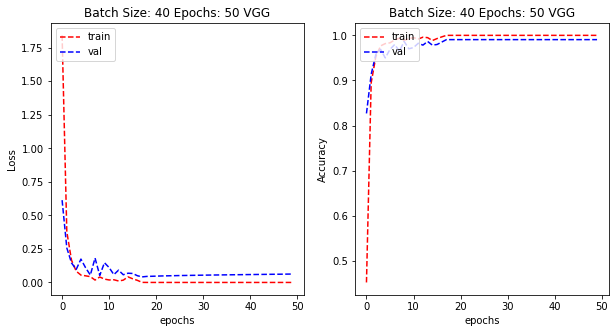

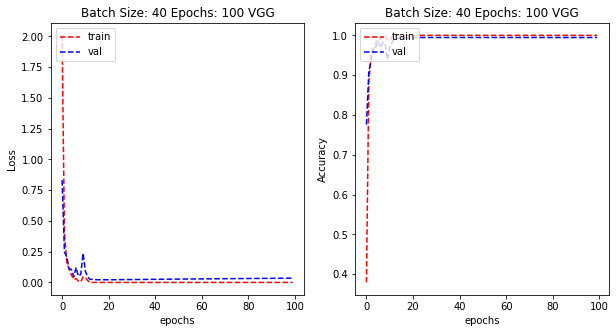

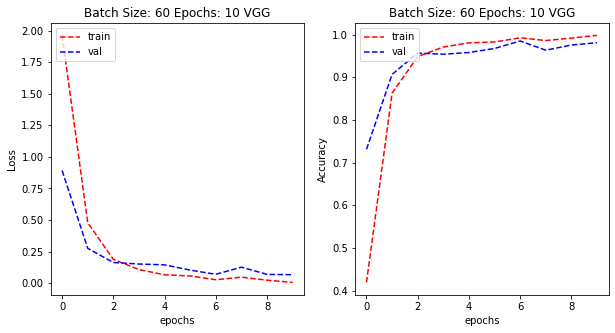

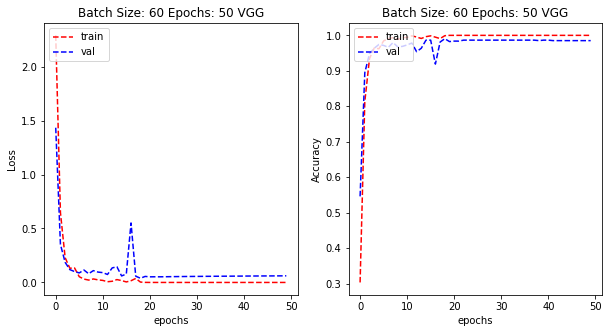

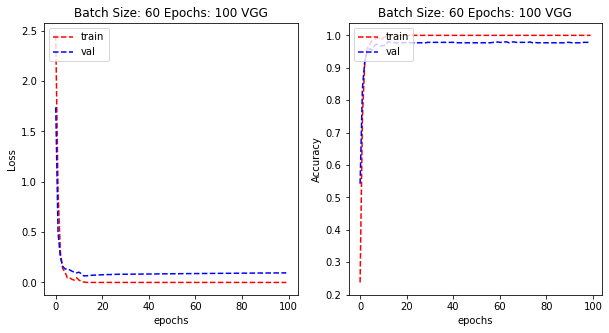

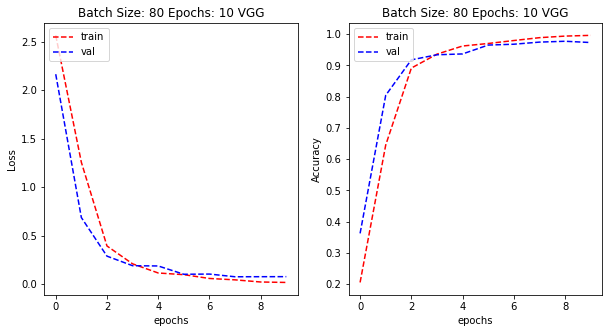

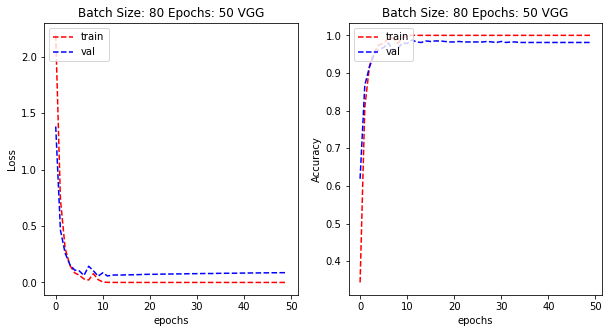

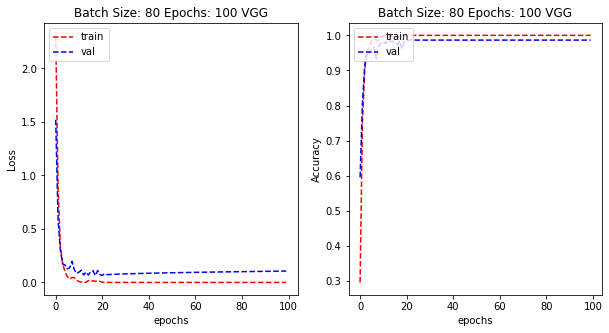

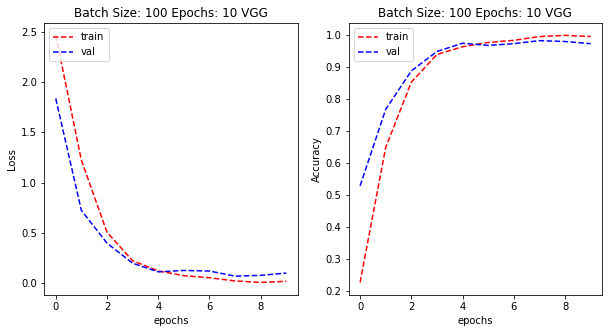

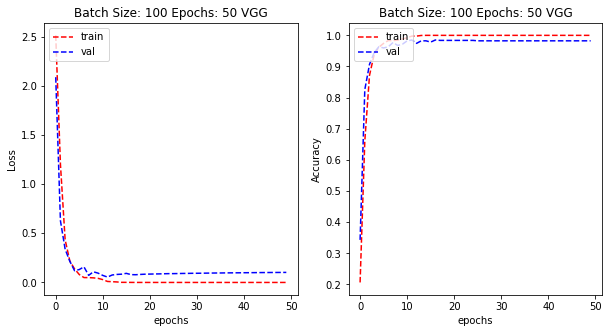

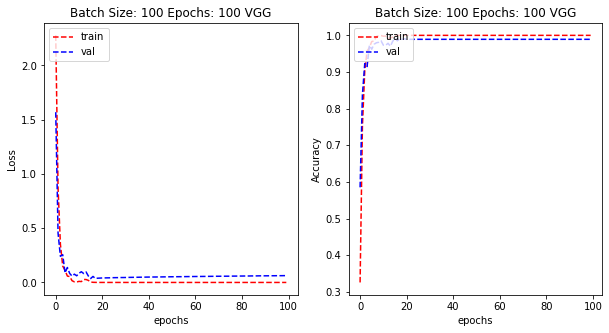

In [23]:
for i in range(0, len(vgg_type_saved_results)):
    plot_title = "Batch Size: {} Epochs: {} VGG".format(vgg_type_saved_results[i]["batch"], vgg_type_saved_results[i]["epoch"])
    plot_learning_curve(vgg_type_saved_results[i]["loss"], vgg_type_saved_results[i]["val_loss"], 
                    vgg_type_saved_results[i]["accuracy"], vgg_type_saved_results[i]["val_accuracy"], 
                    metric_name='Accuracy', title=plot_title)

# Hyper Parameter Tuning - ResNet Shape as better than initial VGG Shape model

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
296/296 [==============================] - 17s 41ms/step - loss: 1.1769 - categorical_accuracy: 0.6877 - val_loss: 0.9620 - val_categorical_accuracy: 0.6162
Epoch 2/10
296/296 [==============================] - 11s 37ms/step - loss: 0.3669 - categorical_accuracy: 0.8905 - val_loss: 0.4493 - val_categorical_accuracy: 0.8459
Epoch 3/10
296/296 [==============================] - 11s 37ms/step - loss: 0.2558 - categorical_accuracy: 0.9219 - val_loss: 0.3010 - val_categorical_accuracy: 0.9095
Epoch 4/10
296/296 [==============================] - 11s 37ms/step - loss: 0.1315 - categorical_accuracy: 0.9588 - val_loss: 0.2258 - val_categorical_accuracy: 0.9365
Epoch 5/10
296/296 [==============================] - 11s 38ms/step - loss: 0.0909 - categorical_accuracy: 0.9730 - val_loss: 0.3106 - val_categorical_accuracy: 0.9068
Epoch 6/10
296/296 [==============================] - 11s 38ms/step - loss: 0.0966 - categorical_accuracy: 0.9719 - val_loss: 0.1742 - val_categorical_accuracy:

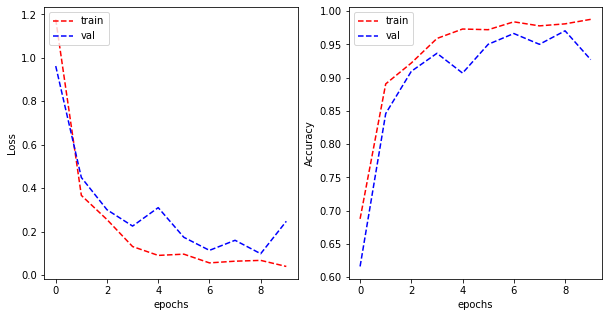

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
296/296 [==============================] - 16s 39ms/step - loss: 1.0922 - categorical_accuracy: 0.6914 - val_loss: 1.0428 - val_categorical_accuracy: 0.6135
Epoch 2/50
296/296 [==============================] - 11s 37ms/step - loss: 0.3787 - categorical_accuracy: 0.8942 - val_loss: 0.3992 - val_categorical_accuracy: 0.8486
Epoch 3/50
296/296 [==============================] - 11s 37ms/step - loss: 0.2341 - categorical_accuracy: 0.9290 - val_loss: 0.2169 - val_categorical_accuracy: 0.9365
Epoch 4/50
296/296 [==============================] - 11s 37ms/step - loss: 0.1362 - categorical_accuracy: 0.9584 - val_loss: 0.5184 - val_categorical_accuracy: 0.8446
Epoch 5/50
296/296 [==============================] - 11s 37ms/step - loss: 0.0963 - categorical_accuracy: 0.9699 - val_loss: 0.0937 - val_categorical_accuracy: 0.9676
Epoch 6/50
296/296 [==============================] - 11s 36ms/step - loss: 0.0802 - categorical_accuracy: 0.9780 - val_loss: 0.1505 - val_categorical_accuracy:

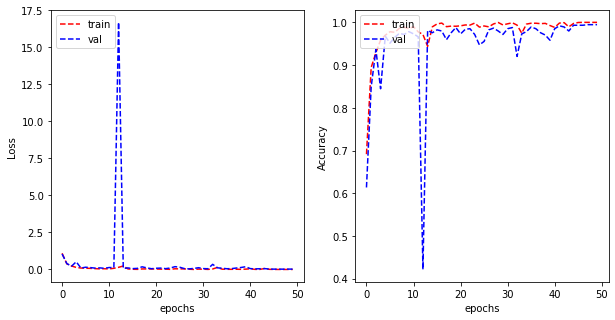

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
296/296 [==============================] - 16s 40ms/step - loss: 1.1001 - categorical_accuracy: 0.6847 - val_loss: 1.4405 - val_categorical_accuracy: 0.5297
Epoch 2/100
296/296 [==============================] - 11s 38ms/step - loss: 0.3697 - categorical_accuracy: 0.8854 - val_loss: 0.3810 - val_categorical_accuracy: 0.8743
Epoch 3/100
296/296 [==============================] - 11s 38ms/step - loss: 0.2419 - categorical_accuracy: 0.9260 - val_loss: 0.2929 - val_categorical_accuracy: 0.8946
Epoch 4/100
296/296 [==============================] - 11s 38ms/step - loss: 0.1090 - categorical_accuracy: 0.9686 - val_loss: 0.1313 - val_categorical_accuracy: 0.9473
Epoch 5/100
296/296 [==============================] - 11s 37ms/step - loss: 0.0695 - categorical_accuracy: 0.9753 - val_loss: 0.3272 - val_categorical_accuracy: 0.8973
Epoch 6/100
296/296 [==============================] - 11s 37ms/step - loss: 0.1024 - categorical_accuracy: 0.9713 - val_loss: 0.0771 - val_categorical_acc

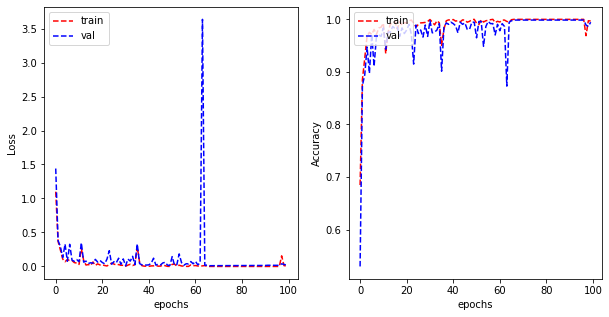

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
148/148 [==============================] - 11s 42ms/step - loss: 1.1779 - categorical_accuracy: 0.6688 - val_loss: 1.4958 - val_categorical_accuracy: 0.4595
Epoch 2/10
148/148 [==============================] - 5s 37ms/step - loss: 0.3295 - categorical_accuracy: 0.8946 - val_loss: 1.0516 - val_categorical_accuracy: 0.6135
Epoch 3/10
148/148 [==============================] - 5s 36ms/step - loss: 0.1872 - categorical_accuracy: 0.9476 - val_loss: 0.3669 - val_categorical_accuracy: 0.8743
Epoch 4/10
148/148 [==============================] - 5s 37ms/step - loss: 0.0998 - categorical_accuracy: 0.9676 - val_loss: 0.3044 - val_categorical_accuracy: 0.9041
Epoch 5/10
148/148 [==============================] - 5s 36ms/step - loss: 0.1118 - categorical_accuracy: 0.9635 - val_loss: 0.3203 - val_categorical_accuracy: 0.9108
Epoch 6/10
148/148 [==============================] - 6s 37ms/step - loss: 0.0737 - categorical_accuracy: 0.9770 - val_loss: 0.1863 - val_categorical_accuracy: 0.94

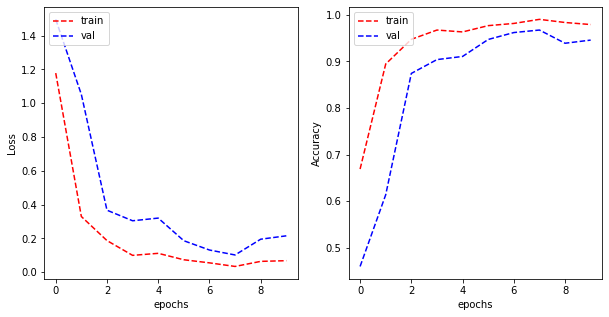

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
148/148 [==============================] - 11s 42ms/step - loss: 1.1010 - categorical_accuracy: 0.6918 - val_loss: 1.3550 - val_categorical_accuracy: 0.4595
Epoch 2/50
148/148 [==============================] - 5s 37ms/step - loss: 0.3275 - categorical_accuracy: 0.8973 - val_loss: 0.9101 - val_categorical_accuracy: 0.6486
Epoch 3/50
148/148 [==============================] - 5s 36ms/step - loss: 0.2310 - categorical_accuracy: 0.9327 - val_loss: 0.3803 - val_categorical_accuracy: 0.8649
Epoch 4/50
148/148 [==============================] - 5s 37ms/step - loss: 0.1555 - categorical_accuracy: 0.9557 - val_loss: 0.2154 - val_categorical_accuracy: 0.9338
Epoch 5/50
148/148 [==============================] - 5s 36ms/step - loss: 0.0761 - categorical_accuracy: 0.9777 - val_loss: 0.5326 - val_categorical_accuracy: 0.8514
Epoch 6/50
148/148 [==============================] - 5s 36ms/step - loss: 0.0671 - categorical_accuracy: 0.9760 - val_loss: 0.1871 - val_categorical_accuracy: 0.94

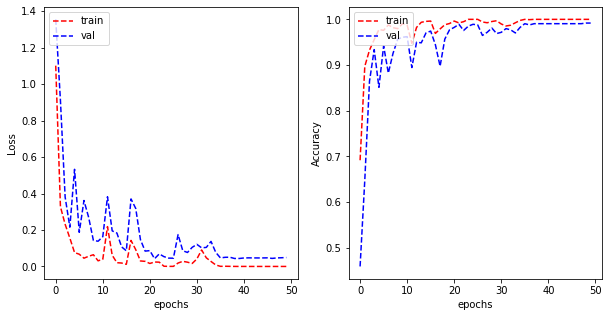

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
148/148 [==============================] - 10s 41ms/step - loss: 1.0614 - categorical_accuracy: 0.7009 - val_loss: 1.3543 - val_categorical_accuracy: 0.4595
Epoch 2/100
148/148 [==============================] - 5s 36ms/step - loss: 0.2967 - categorical_accuracy: 0.9104 - val_loss: 0.9103 - val_categorical_accuracy: 0.6743
Epoch 3/100
148/148 [==============================] - 5s 35ms/step - loss: 0.1641 - categorical_accuracy: 0.9459 - val_loss: 0.4265 - val_categorical_accuracy: 0.8568
Epoch 4/100
148/148 [==============================] - 5s 36ms/step - loss: 0.1265 - categorical_accuracy: 0.9621 - val_loss: 0.3438 - val_categorical_accuracy: 0.8919
Epoch 5/100
148/148 [==============================] - 5s 36ms/step - loss: 0.1083 - categorical_accuracy: 0.9676 - val_loss: 0.4197 - val_categorical_accuracy: 0.8824
Epoch 6/100
148/148 [==============================] - 5s 36ms/step - loss: 0.0671 - categorical_accuracy: 0.9787 - val_loss: 0.1490 - val_categorical_accuracy

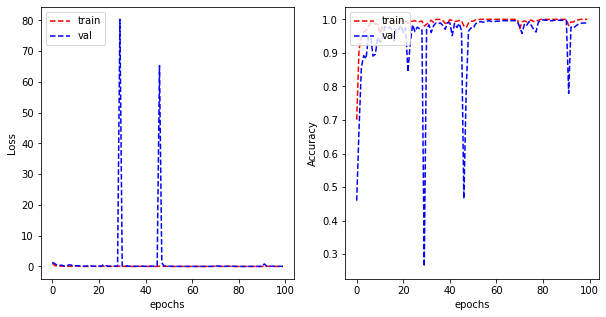

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
74/74 [==============================] - 9s 53ms/step - loss: 1.2902 - categorical_accuracy: 0.6404 - val_loss: 1.3986 - val_categorical_accuracy: 0.4595
Epoch 2/10
74/74 [==============================] - 3s 39ms/step - loss: 0.4067 - categorical_accuracy: 0.8797 - val_loss: 1.7389 - val_categorical_accuracy: 0.4595
Epoch 3/10
74/74 [==============================] - 3s 40ms/step - loss: 0.1953 - categorical_accuracy: 0.9338 - val_loss: 1.8087 - val_categorical_accuracy: 0.4757
Epoch 4/10
74/74 [==============================] - 3s 40ms/step - loss: 0.1271 - categorical_accuracy: 0.9588 - val_loss: 0.7992 - val_categorical_accuracy: 0.7378
Epoch 5/10
74/74 [==============================] - 3s 40ms/step - loss: 0.0836 - categorical_accuracy: 0.9716 - val_loss: 1.0027 - val_categorical_accuracy: 0.6986
Epoch 6/10
74/74 [==============================] - 3s 41ms/step - loss: 0.0602 - categorical_accuracy: 0.9804 - val_loss: 0.5187 - val_categorical_accuracy: 0.8257
Epoch 7/10

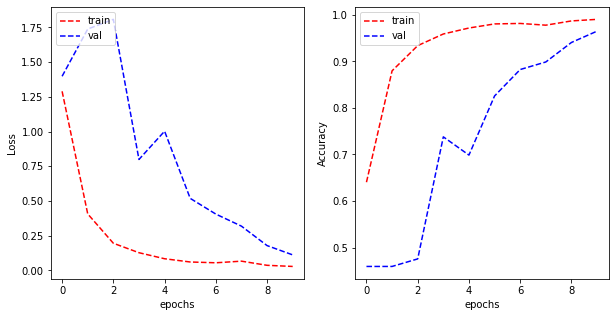

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
74/74 [==============================] - 8s 51ms/step - loss: 1.3493 - categorical_accuracy: 0.6529 - val_loss: 1.5993 - val_categorical_accuracy: 0.4595
Epoch 2/50
74/74 [==============================] - 3s 39ms/step - loss: 0.3123 - categorical_accuracy: 0.8942 - val_loss: 1.7256 - val_categorical_accuracy: 0.4595
Epoch 3/50
74/74 [==============================] - 3s 39ms/step - loss: 0.1786 - categorical_accuracy: 0.9473 - val_loss: 1.2553 - val_categorical_accuracy: 0.5324
Epoch 4/50
74/74 [==============================] - 3s 40ms/step - loss: 0.1006 - categorical_accuracy: 0.9713 - val_loss: 1.0622 - val_categorical_accuracy: 0.6689
Epoch 5/50
74/74 [==============================] - 3s 40ms/step - loss: 0.0908 - categorical_accuracy: 0.9696 - val_loss: 1.1426 - val_categorical_accuracy: 0.7189
Epoch 6/50
74/74 [==============================] - 3s 42ms/step - loss: 0.0467 - categorical_accuracy: 0.9848 - val_loss: 0.4212 - val_categorical_accuracy: 0.8919
Epoch 7/50

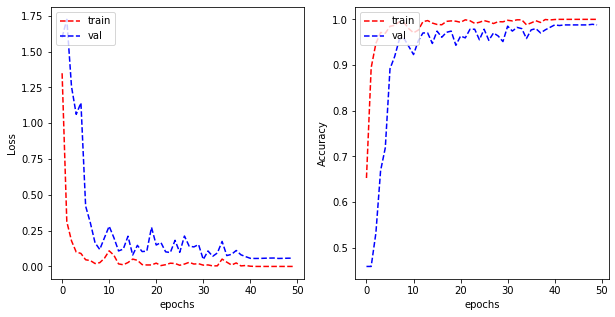

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
74/74 [==============================] - 8s 55ms/step - loss: 1.3045 - categorical_accuracy: 0.6462 - val_loss: 1.3309 - val_categorical_accuracy: 0.4595
Epoch 2/100
74/74 [==============================] - 3s 37ms/step - loss: 0.3080 - categorical_accuracy: 0.9033 - val_loss: 1.3346 - val_categorical_accuracy: 0.4595
Epoch 3/100
74/74 [==============================] - 3s 38ms/step - loss: 0.1528 - categorical_accuracy: 0.9554 - val_loss: 0.8297 - val_categorical_accuracy: 0.6649
Epoch 4/100
74/74 [==============================] - 3s 38ms/step - loss: 0.1094 - categorical_accuracy: 0.9652 - val_loss: 0.5485 - val_categorical_accuracy: 0.8054
Epoch 5/100
74/74 [==============================] - 3s 38ms/step - loss: 0.0943 - categorical_accuracy: 0.9723 - val_loss: 0.5891 - val_categorical_accuracy: 0.8378
Epoch 6/100
74/74 [==============================] - 3s 38ms/step - loss: 0.0436 - categorical_accuracy: 0.9855 - val_loss: 0.3945 - val_categorical_accuracy: 0.9122
Epoc

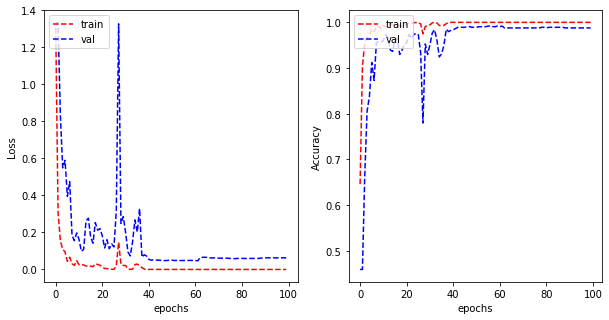

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 7s 64ms/step - loss: 1.4791 - categorical_accuracy: 0.6002 - val_loss: 1.3596 - val_categorical_accuracy: 0.4595
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.3396 - categorical_accuracy: 0.8908 - val_loss: 1.7187 - val_categorical_accuracy: 0.4595
Epoch 3/10
50/50 [==============================] - 2s 39ms/step - loss: 0.1912 - categorical_accuracy: 0.9402 - val_loss: 1.4288 - val_categorical_accuracy: 0.4595
Epoch 4/10
50/50 [==============================] - 2s 39ms/step - loss: 0.1412 - categorical_accuracy: 0.9523 - val_loss: 1.2032 - val_categorical_accuracy: 0.5149
Epoch 5/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0868 - categorical_accuracy: 0.9730 - val_loss: 1.1035 - val_categorical_accuracy: 0.5838
Epoch 6/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0635 - categorical_accuracy: 0.9811 - val_loss: 0.9071 - val_categorical_accuracy: 0.6757
Epoch 7/10

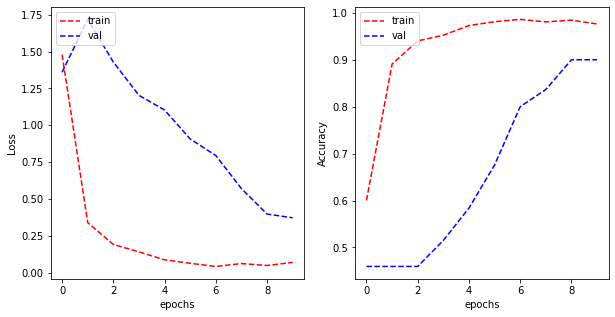

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 7s 53ms/step - loss: 1.4405 - categorical_accuracy: 0.6269 - val_loss: 1.3810 - val_categorical_accuracy: 0.4595
Epoch 2/50
50/50 [==============================] - 2s 38ms/step - loss: 0.3501 - categorical_accuracy: 0.8864 - val_loss: 1.4697 - val_categorical_accuracy: 0.4595
Epoch 3/50
50/50 [==============================] - 2s 38ms/step - loss: 0.1926 - categorical_accuracy: 0.9358 - val_loss: 1.6444 - val_categorical_accuracy: 0.4595
Epoch 4/50
50/50 [==============================] - 2s 38ms/step - loss: 0.1219 - categorical_accuracy: 0.9598 - val_loss: 2.3308 - val_categorical_accuracy: 0.4595
Epoch 5/50
50/50 [==============================] - 2s 39ms/step - loss: 0.0622 - categorical_accuracy: 0.9821 - val_loss: 2.3028 - val_categorical_accuracy: 0.4797
Epoch 6/50
50/50 [==============================] - 2s 39ms/step - loss: 0.0687 - categorical_accuracy: 0.9790 - val_loss: 1.3691 - val_categorical_accuracy: 0.6203
Epoch 7/50

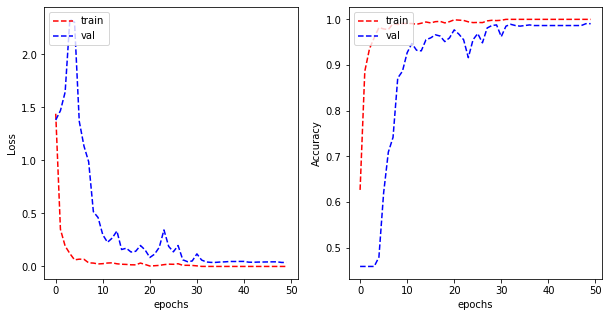

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
50/50 [==============================] - 7s 61ms/step - loss: 1.5183 - categorical_accuracy: 0.6083 - val_loss: 1.3333 - val_categorical_accuracy: 0.4595
Epoch 2/100
50/50 [==============================] - 2s 39ms/step - loss: 0.3237 - categorical_accuracy: 0.8912 - val_loss: 1.5317 - val_categorical_accuracy: 0.4595
Epoch 3/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1739 - categorical_accuracy: 0.9463 - val_loss: 1.7438 - val_categorical_accuracy: 0.4595
Epoch 4/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1214 - categorical_accuracy: 0.9584 - val_loss: 2.1657 - val_categorical_accuracy: 0.4595
Epoch 5/100
50/50 [==============================] - 2s 39ms/step - loss: 0.0906 - categorical_accuracy: 0.9733 - val_loss: 1.0524 - val_categorical_accuracy: 0.6108
Epoch 6/100
50/50 [==============================] - 2s 39ms/step - loss: 0.0620 - categorical_accuracy: 0.9784 - val_loss: 0.6462 - val_categorical_accuracy: 0.7946
Epoc

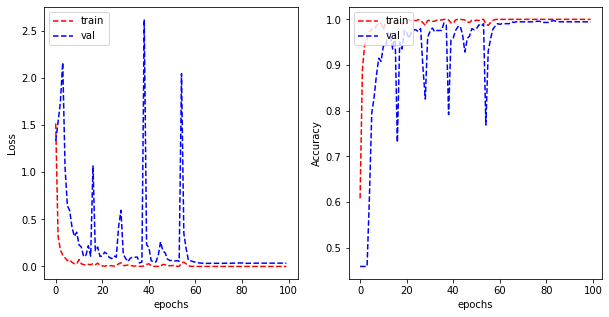

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
37/37 [==============================] - 7s 80ms/step - loss: 1.6928 - categorical_accuracy: 0.5813 - val_loss: 1.3500 - val_categorical_accuracy: 0.4595
Epoch 2/10
37/37 [==============================] - 2s 42ms/step - loss: 0.3883 - categorical_accuracy: 0.8726 - val_loss: 1.4241 - val_categorical_accuracy: 0.4595
Epoch 3/10
37/37 [==============================] - 2s 43ms/step - loss: 0.1854 - categorical_accuracy: 0.9402 - val_loss: 1.5110 - val_categorical_accuracy: 0.4595
Epoch 4/10
37/37 [==============================] - 2s 41ms/step - loss: 0.1126 - categorical_accuracy: 0.9686 - val_loss: 1.7972 - val_categorical_accuracy: 0.4595
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0918 - categorical_accuracy: 0.9703 - val_loss: 1.5335 - val_categorical_accuracy: 0.4649
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.0661 - categorical_accuracy: 0.9753 - val_loss: 1.2615 - val_categorical_accuracy: 0.5189
Epoch 7/10

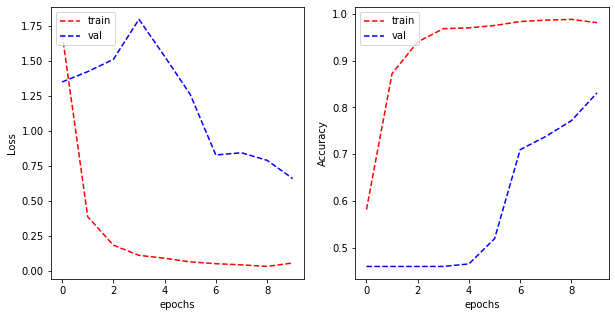

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 6s 62ms/step - loss: 1.5958 - categorical_accuracy: 0.5799 - val_loss: 1.3243 - val_categorical_accuracy: 0.4595
Epoch 2/50
37/37 [==============================] - 2s 41ms/step - loss: 0.4083 - categorical_accuracy: 0.8665 - val_loss: 1.3376 - val_categorical_accuracy: 0.4595
Epoch 3/50
37/37 [==============================] - 2s 42ms/step - loss: 0.1987 - categorical_accuracy: 0.9395 - val_loss: 1.3832 - val_categorical_accuracy: 0.4595
Epoch 4/50
37/37 [==============================] - 2s 41ms/step - loss: 0.1263 - categorical_accuracy: 0.9611 - val_loss: 1.2499 - val_categorical_accuracy: 0.4730
Epoch 5/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0961 - categorical_accuracy: 0.9709 - val_loss: 1.3474 - val_categorical_accuracy: 0.4608
Epoch 6/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0801 - categorical_accuracy: 0.9747 - val_loss: 1.2954 - val_categorical_accuracy: 0.5486
Epoch 7/50

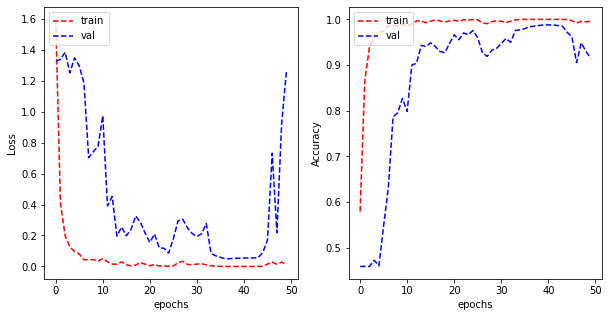

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
37/37 [==============================] - 7s 71ms/step - loss: 1.6715 - categorical_accuracy: 0.5776 - val_loss: 1.3608 - val_categorical_accuracy: 0.4595
Epoch 2/100
37/37 [==============================] - 2s 41ms/step - loss: 0.3965 - categorical_accuracy: 0.8699 - val_loss: 1.3773 - val_categorical_accuracy: 0.4595
Epoch 3/100
37/37 [==============================] - 2s 41ms/step - loss: 0.1897 - categorical_accuracy: 0.9385 - val_loss: 1.4151 - val_categorical_accuracy: 0.4595
Epoch 4/100
37/37 [==============================] - 2s 40ms/step - loss: 0.1652 - categorical_accuracy: 0.9527 - val_loss: 1.9956 - val_categorical_accuracy: 0.4595
Epoch 5/100
37/37 [==============================] - 2s 43ms/step - loss: 0.1255 - categorical_accuracy: 0.9588 - val_loss: 1.3769 - val_categorical_accuracy: 0.4351
Epoch 6/100
37/37 [==============================] - 2s 41ms/step - loss: 0.0715 - categorical_accuracy: 0.9784 - val_loss: 1.5946 - val_categorical_accuracy: 0.4919
Epoc

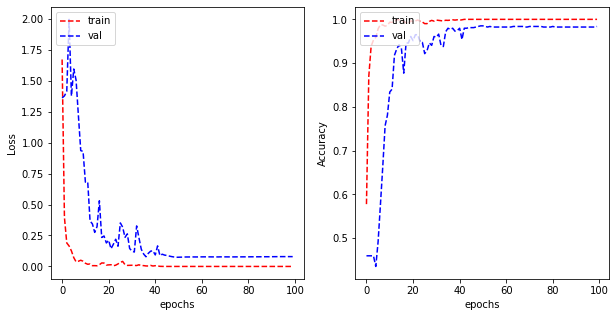

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
30/30 [==============================] - 7s 78ms/step - loss: 1.8123 - categorical_accuracy: 0.5363 - val_loss: 1.3452 - val_categorical_accuracy: 0.4595
Epoch 2/10
30/30 [==============================] - 1s 44ms/step - loss: 0.4530 - categorical_accuracy: 0.8452 - val_loss: 1.3404 - val_categorical_accuracy: 0.4595
Epoch 3/10
30/30 [==============================] - 1s 45ms/step - loss: 0.1988 - categorical_accuracy: 0.9317 - val_loss: 1.3280 - val_categorical_accuracy: 0.4595
Epoch 4/10
30/30 [==============================] - 1s 44ms/step - loss: 0.1096 - categorical_accuracy: 0.9649 - val_loss: 1.4707 - val_categorical_accuracy: 0.4595
Epoch 5/10
30/30 [==============================] - 1s 45ms/step - loss: 0.1001 - categorical_accuracy: 0.9713 - val_loss: 1.3598 - val_categorical_accuracy: 0.4595
Epoch 6/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0782 - categorical_accuracy: 0.9740 - val_loss: 1.1741 - val_categorical_accuracy: 0.4946
Epoch 7/10

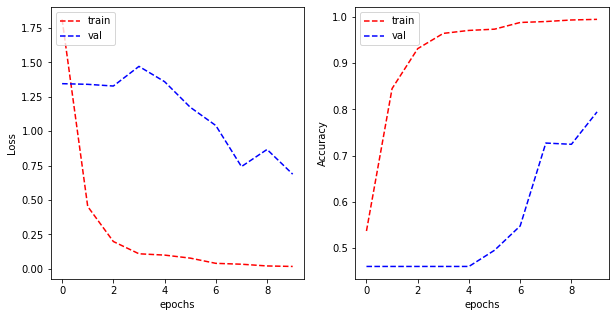

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 6s 79ms/step - loss: 2.0001 - categorical_accuracy: 0.5282 - val_loss: 1.3412 - val_categorical_accuracy: 0.4595
Epoch 2/50
30/30 [==============================] - 1s 44ms/step - loss: 0.4653 - categorical_accuracy: 0.8418 - val_loss: 1.3598 - val_categorical_accuracy: 0.4595
Epoch 3/50
30/30 [==============================] - 1s 43ms/step - loss: 0.1699 - categorical_accuracy: 0.9436 - val_loss: 1.3399 - val_categorical_accuracy: 0.4595
Epoch 4/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0947 - categorical_accuracy: 0.9676 - val_loss: 1.3974 - val_categorical_accuracy: 0.4595
Epoch 5/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0681 - categorical_accuracy: 0.9784 - val_loss: 1.5140 - val_categorical_accuracy: 0.3365
Epoch 6/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0681 - categorical_accuracy: 0.9770 - val_loss: 1.6586 - val_categorical_accuracy: 0.3270
Epoch 7/50

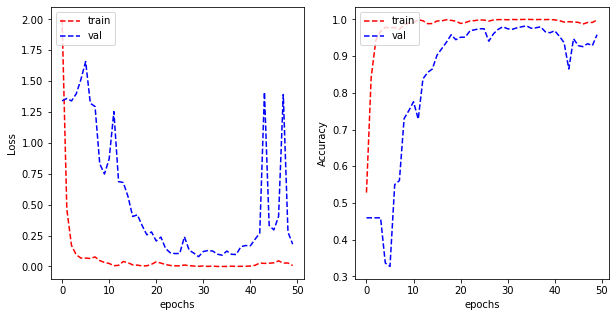

(28, 28)
Found 2959 validated image filenames belonging to 5 classes.
(28, 28)
Found 740 validated image filenames belonging to 5 classes.


c:\Users\platt\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
30/30 [==============================] - 7s 86ms/step - loss: 1.7455 - categorical_accuracy: 0.5688 - val_loss: 1.3365 - val_categorical_accuracy: 0.4595
Epoch 2/100
30/30 [==============================] - 1s 45ms/step - loss: 0.3857 - categorical_accuracy: 0.8675 - val_loss: 1.4597 - val_categorical_accuracy: 0.4595
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 0.1805 - categorical_accuracy: 0.9409 - val_loss: 1.8124 - val_categorical_accuracy: 0.4595
Epoch 4/100
30/30 [==============================] - 1s 46ms/step - loss: 0.0762 - categorical_accuracy: 0.9750 - val_loss: 2.2828 - val_categorical_accuracy: 0.4595
Epoch 5/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0721 - categorical_accuracy: 0.9787 - val_loss: 2.5727 - val_categorical_accuracy: 0.4595
Epoch 6/100
30/30 [==============================] - 1s 46ms/step - loss: 0.0559 - categorical_accuracy: 0.9811 - val_loss: 2.0819 - val_categorical_accuracy: 0.4595
Epoc

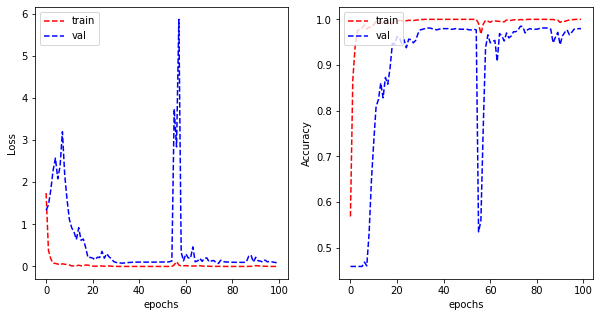

In [18]:
# want to tune batch size, epochs
parameters = {"batch_size": [10, 20, 40, 60, 80, 100], "epochs" : [10, 50, 100]}

# save results of tuning for later accessing 
resnet_shape_saved_results = {}
attempt = 0

# use parameter grid to generate permutations 
model_parameters = list(ParameterGrid(parameters))

for each in model_parameters:
    # need to tune batch size, so we initalise and build model + generator according to batch size
    shape_train_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')
    shape_val_datagen = ImageDataGenerator(rescale=1.0/255, data_format='channels_last')

    resnet_shape_model = CNNModel()

    # Baseline ResNet Shape Model Data Generators
    resnet_shape_model.train_generator = resnet_shape_model.create_data_generator(\
        shape_train_data,shape_train_datagen, each["batch_size"],"shape")

    resnet_shape_model.val_generator = resnet_shape_model.create_data_generator(\
        shape_val_data,shape_val_datagen,each["batch_size"],"shape")

    # build and compile the model for tuning 
    resnet_shape_model.build_resnet_model(TOTAL_SHAPES)
    resnet_shape_model.compile_resnet_model()

    # fit the model 
    resnet_shape_fit = resnet_shape_model.model.fit_generator(resnet_shape_model.train_generator, validation_data=resnet_shape_model.val_generator,\
           epochs=each["epochs"],verbose=1)
    
    resnet_shape_saved_results[attempt] = {"batch":each["batch_size"], "epoch":each["epochs"], "best_val_accuracy":max(resnet_shape_fit.history["val_categorical_accuracy"]), \
        "loss":resnet_shape_fit.history['loss'], "val_loss":resnet_shape_fit.history['val_loss'], \
        "accuracy":resnet_shape_fit.history['categorical_accuracy'], "val_accuracy":resnet_shape_fit.history['val_categorical_accuracy']}
    attempt += 1
    print("For batch size {} and epochs of {}, performance:".format(each["batch_size"], each["epochs"]))
    plot_learning_curve(resnet_shape_fit.history['loss'], resnet_shape_fit.history['val_loss'], 
                    resnet_shape_fit.history['categorical_accuracy'], resnet_shape_fit.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [19]:
resnet_shape_saved_results

{0: {'batch': 10,
  'epoch': 10,
  'best_val_accuracy': 0.9702702760696411,
  'loss': [1.1768574714660645,
   0.3669441044330597,
   0.25579482316970825,
   0.131538987159729,
   0.09087240695953369,
   0.09661667048931122,
   0.05642884224653244,
   0.06425224244594574,
   0.06796557456254959,
   0.04006797447800636],
  'val_loss': [0.9619593620300293,
   0.44929665327072144,
   0.3010178506374359,
   0.22578327357769012,
   0.31062111258506775,
   0.1741970330476761,
   0.11406715959310532,
   0.16044293344020844,
   0.09868114441633224,
   0.247815802693367],
  'accuracy': [0.6877323389053345,
   0.8905035257339478,
   0.921933114528656,
   0.9587698578834534,
   0.972963809967041,
   0.9719499945640564,
   0.9837782979011536,
   0.9776951670646667,
   0.9807367324829102,
   0.9874957799911499],
  'val_accuracy': [0.616216242313385,
   0.8459459543228149,
   0.9094594717025757,
   0.9364864826202393,
   0.9067567586898804,
   0.949999988079071,
   0.9662162065505981,
   0.9499999880

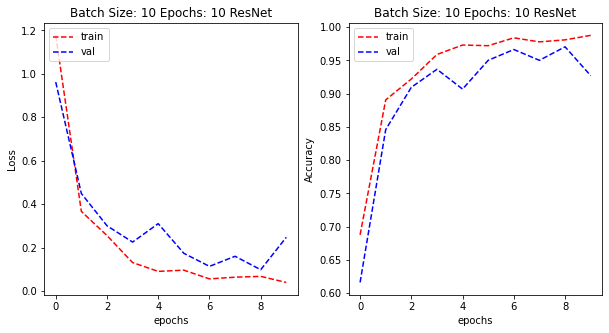

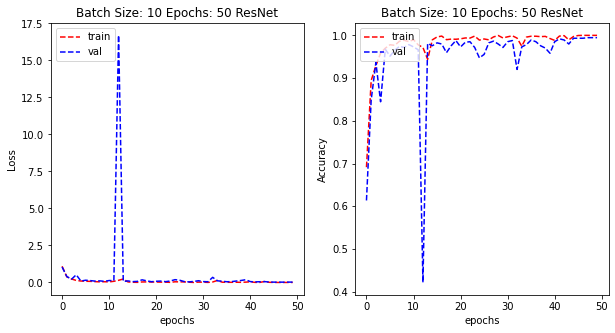

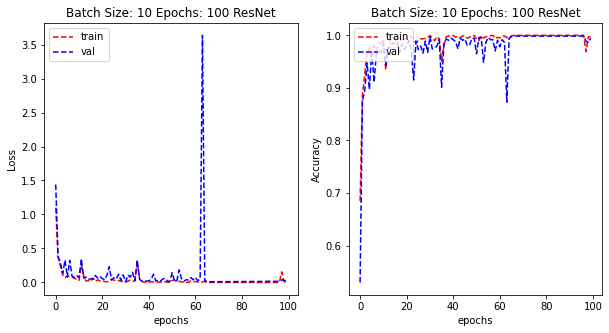

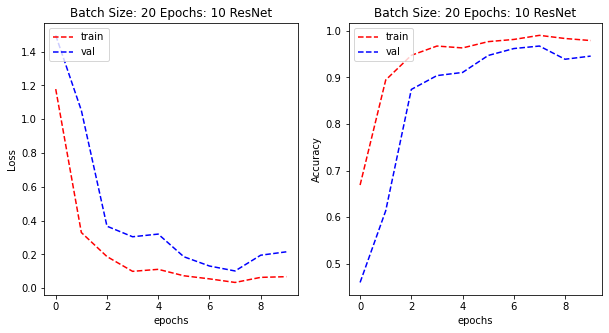

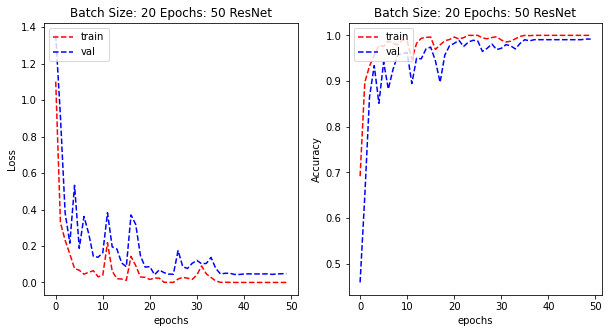

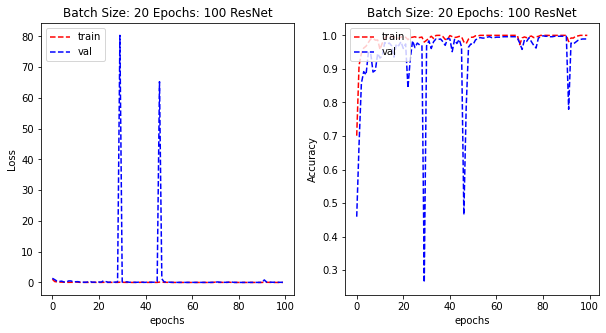

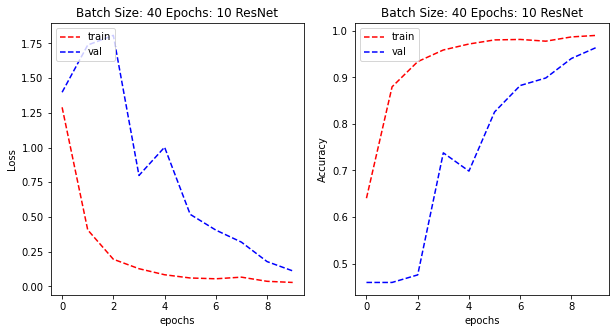

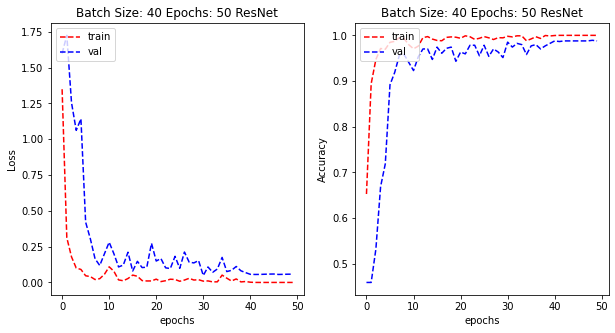

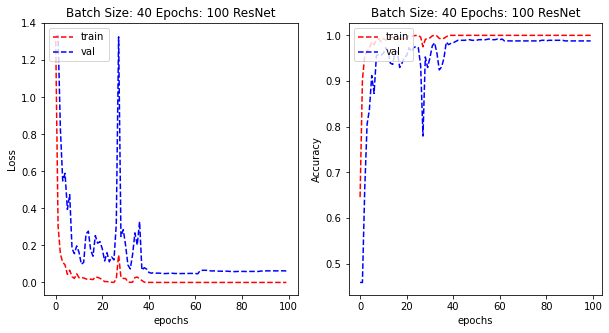

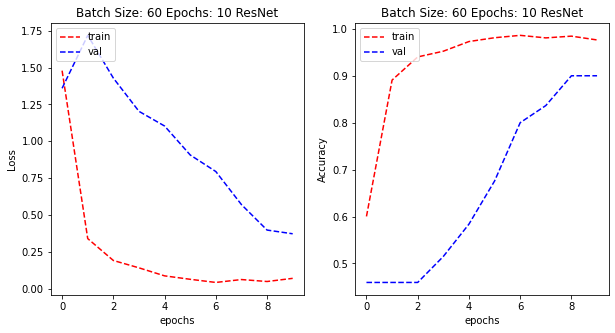

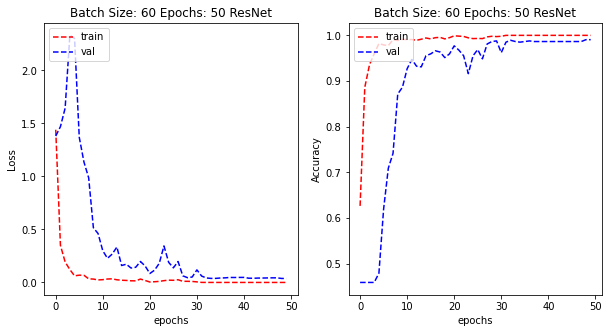

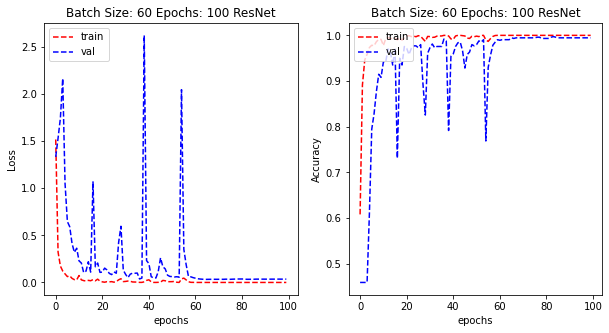

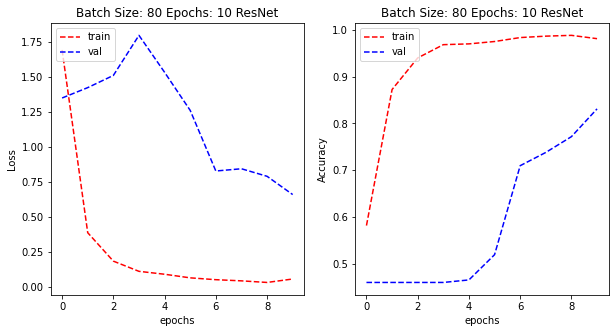

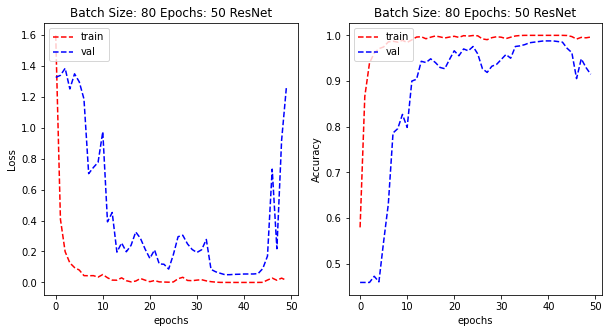

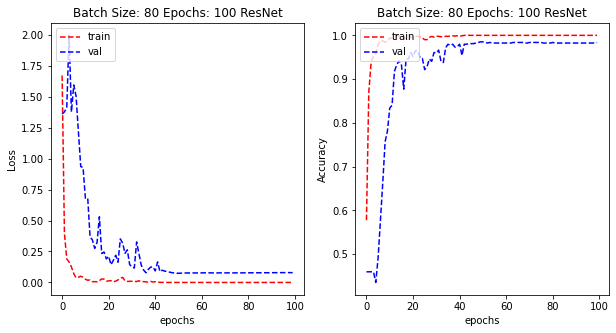

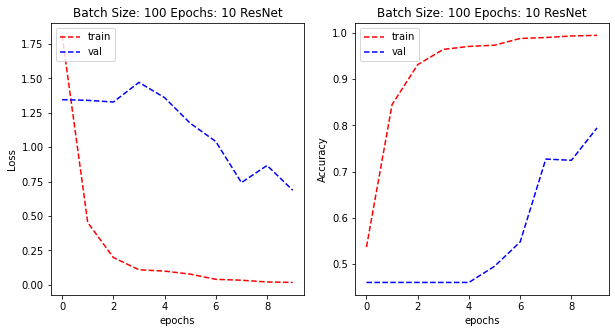

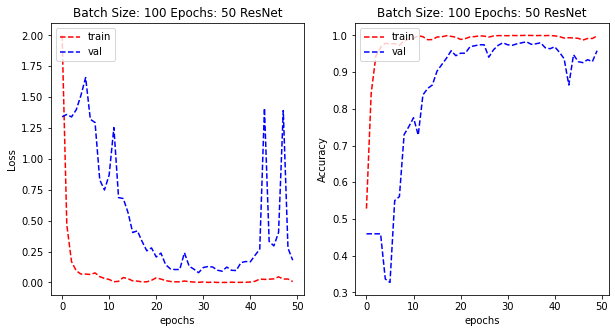

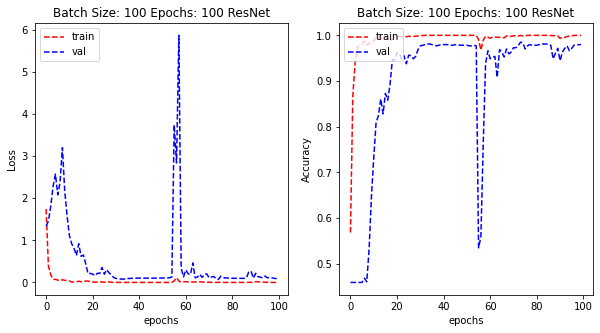

In [24]:
for i in range(0, len(resnet_shape_saved_results)):
    plot_title = "Batch Size: {} Epochs: {} ResNet".format(resnet_shape_saved_results[i]["batch"], resnet_shape_saved_results[i]["epoch"])
    plot_learning_curve(resnet_shape_saved_results[i]["loss"], resnet_shape_saved_results[i]["val_loss"], 
                    resnet_shape_saved_results[i]["accuracy"], resnet_shape_saved_results[i]["val_accuracy"], 
                    metric_name='Accuracy', title=plot_title)

Further tuning -> anything we want to tune within the layers like accuracy or loss function etc., need to add them as variables we pass in in the init in the CNN class, then simply pass each into the CNNModel() line, and within the class, pass in as a variable as well as defining the default as used in the baseline model, with the different values overrriding the default. 

## Ultimate Judgement - Sign-Shape

## Ultimate Judgement - Sign-Type

# Deployment on Independent Data

In [21]:
# read in and prep of independent data